This document includes exploratory data analysis and predictive modeling aimed at answering our primary question: **What factors lead to movie success, where success is defined quantitatively by the average vote rating?**

## EDA

In this section, we look at genre impact, temporal trends, star power, and linguistic influence. We also consider feature distributions of financial variables, and perform correlation analysis to understand the relationship between several numerical features.

In [1]:
import pandas as pd 

df = pd.read_csv("final_movie_table.csv")

In [2]:
df.head()

movie_id                   movie_name    budget                    genres  \
0       862                    Toy Story  30000000   Animation|Comedy|Family   
1      8844                      Jumanji  65000000  Adventure|Fantasy|Family   
2     15602             Grumpier Old Men         0            Romance|Comedy   
3     31357            Waiting to Exhale  16000000      Comedy|Drama|Romance   
4     11862  Father of the Bride Part II         0                    Comedy   

  original_language               original_title release_date  release_year  \
0                en                    Toy Story   1995-10-30        1995.0   
1                en                      Jumanji   1995-12-15        1995.0   
2                en             Grumpier Old Men   1995-12-22        1995.0   
3                en            Waiting to Exhale   1995-12-22        1995.0   
4                en  Father of the Bride Part II   1995-02-10        1995.0   

       revenue  runtime    status  adult  vote_average  vote_count  \
0  373554033.0     81.0  Released  False           7.7      5415.0   
1  262797249.0    104.0  Released  False           6.9      2413.0   
2          0.0    101.0  Released  False           6.5        92.0   
3   81452156.0    127.0  Released  False           6.1        34.0   
4   76578911.0    106.0  Released  False           5.7       173.0   

        lead_actor  keyword_count  user_avg_rating  user_rating_count  
0        Tom Hanks            9.0         3.888157            66008.0  
1   Robin Williams            6.0         3.236953            26060.0  
2   Walter Matthau            4.0         3.175550            15497.0  
3  Whitney Houston            5.0         2.875713             2981.0  
4     Steve Martin            9.0         3.079565            15258.0

In [3]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46629 entries, 0 to 46628
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           46629 non-null  int64  
 1   movie_name         46625 non-null  object 
 2   budget             46629 non-null  int64  
 3   genres             44104 non-null  object 
 4   original_language  46618 non-null  object 
 5   original_title     46629 non-null  object 
 6   release_date       46541 non-null  object 
 7   release_year       46541 non-null  float64
 8   revenue            46625 non-null  float64
 9   runtime            46361 non-null  float64
 10  status             46543 non-null  object 
 11  adult              46629 non-null  bool   
 12  vote_average       46625 non-null  float64
 13  vote_count         46625 non-null  float64
 14  lead_actor         44137 non-null  object 
 15  keyword_count      46628 non-null  float64
 16  user_avg_rating    458

movie_id                0
movie_name              4
budget                  0
genres               2525
original_language      11
original_title          0
release_date           88
release_year           88
revenue                 4
runtime               268
status                 86
adult                   0
vote_average            4
vote_count              4
lead_actor           2492
keyword_count           1
user_avg_rating       745
user_rating_count     745
dtype: int64

#### **Genre Impact:** Which movie genres typically receive the highest critical acclaim (average rating) from audiences, and which receive the lowest?

In [4]:
df_genres = (
    df.assign(genre=df['genres'].str.split('|'))
      .explode('genre')
)

genre_vote_avg = (
    df_genres.groupby('genre')['vote_average']
             .mean()
             .sort_values(ascending=False)
             .reset_index()
)

genre_counts = (
    df_genres['genre']
        .value_counts()
        .reset_index()
)

genre_counts.columns = ['genre', 'count']

genre_summary = genre_vote_avg.merge(genre_counts, on='genre')

genre_summary

genre  vote_average  count
0         Animation      6.271407   1998
1           History      6.157814   1427
2               War      6.036573   1348
3             Drama      5.892609  20809
4             Music      5.878528   1630
5             Crime      5.875427   4387
6           Mystery      5.824085   2541
7       Documentary      5.811136   4050
8           Romance      5.791492   6923
9           Fantasy      5.762348   2385
10          Foreign      5.750387   1681
11           Family      5.746556   2831
12           Comedy      5.708577  13467
13        Adventure      5.672958   3587
14         Thriller      5.616233   7794
15           Action      5.579768   6730
16  Science Fiction      5.336978   3140
17         TV Movie      5.237042    793
18           Horror      5.225084   4762
19          Western      5.134278   1059

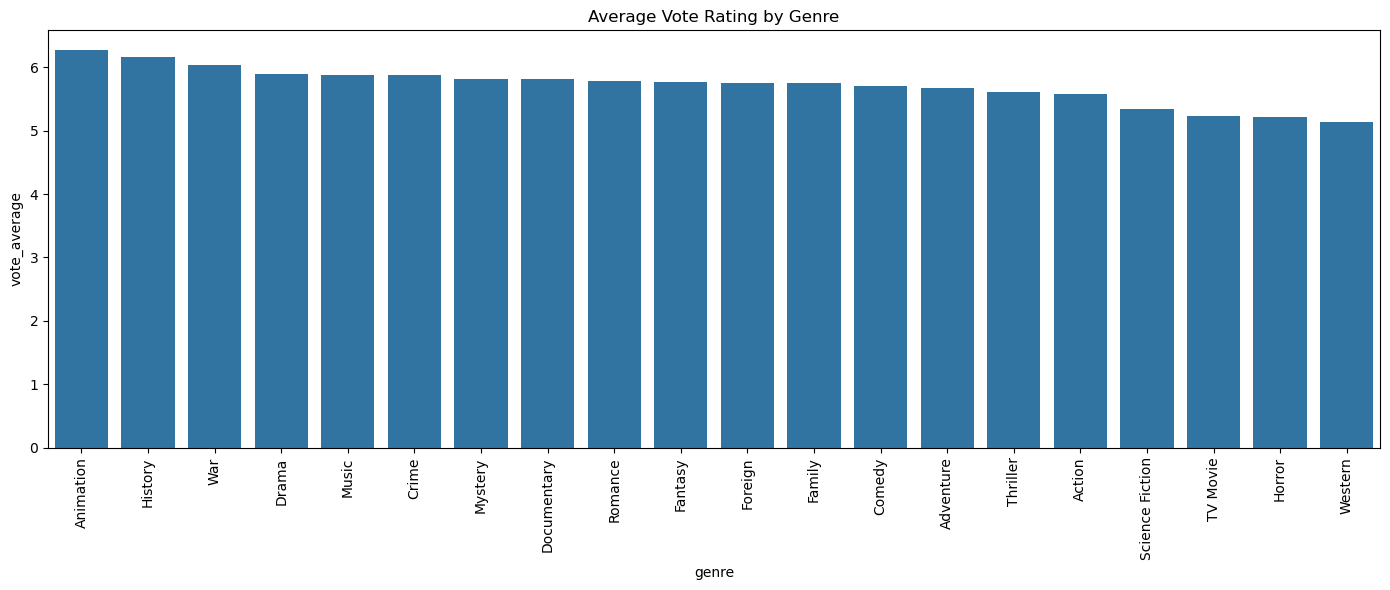

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

genre_summary_sorted = genre_summary.sort_values('vote_average', ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(
    data=genre_summary_sorted,
    x='genre',
    y='vote_average'
)
plt.xticks(rotation=90)
plt.title('Average Vote Rating by Genre')
plt.tight_layout()
plt.show()

The visualization shows that Animation, History, and War films receive the highest average ratings, while genres like Western, Horror, and TV Movie score lower.

#### **Temporal Trends:** How does the era of release influence a movie's average rating?

In [6]:
# Drop missing years
df_year = df.dropna(subset=['release_year']).copy()

# Convert release_year to int and then to category
df_year['release_year'] = df_year['release_year'].astype(int)
df_year['release_year_cat'] = df_year['release_year'].astype('category')

In [7]:
def categorize_year(y):
    if y < 1920:  return 'Pre-1920'
    elif y < 1950: return '1920–1949'
    elif y < 1980: return '1950–1979'
    elif y < 2000: return '1980–1999'
    elif y < 2010: return '2000–2009'
    else: return '2010–2019'   # everything 2010–2019

df_year['year_group'] = df_year['release_year'].apply(categorize_year)
df_year['year_group'] = df_year['year_group'].astype('category')

In [8]:
year_group_summary = (
    df_year.groupby('year_group')
           .agg(
               vote_average_mean=('vote_average', 'mean'),
               movie_count=('movie_id', 'count')
           )
           .reset_index()
           .sort_values('year_group')
)

year_group_summary

/var/folders/vs/6_7m30556xz7sfpjhfw5bn240000gn/T/ipykernel_53655/1902286050.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_year.groupby('year_group')


year_group  vote_average_mean  movie_count
0  1920–1949           5.367426         3337
1  1950–1979           5.665494         8332
2  1980–1999           5.566091         9729
3  2000–2009           5.588039        11479
4  2010–2019           5.718380        13319
5   Pre-1920           5.387246          345

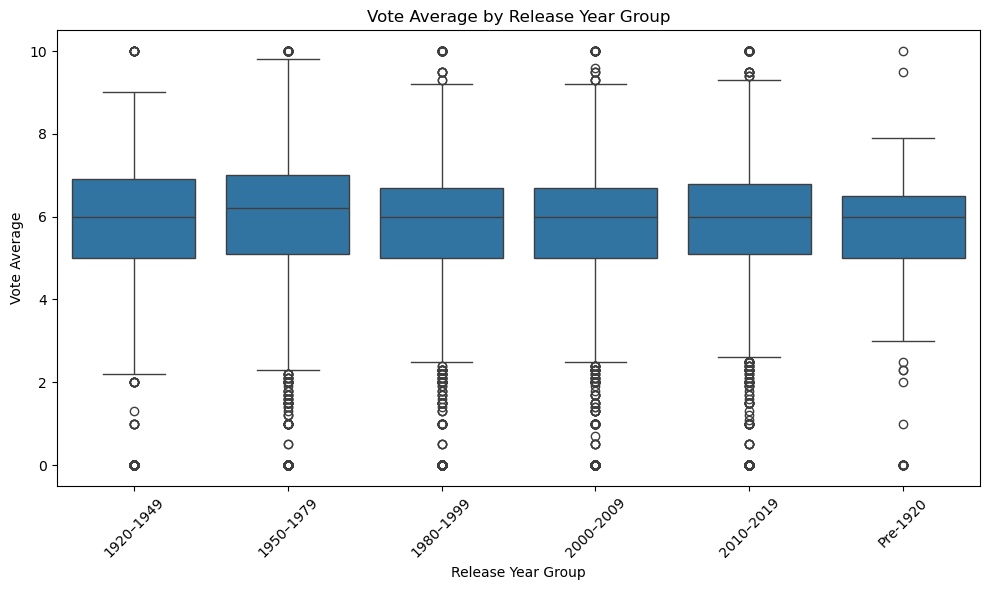

In [9]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_year, x='year_group', y='vote_average')
plt.xticks(rotation=45)
plt.title('Vote Average by Release Year Group')
plt.xlabel('Release Year Group')
plt.ylabel('Vote Average')
plt.tight_layout()
plt.show()

We grouped release years into broader historical categories to reduce noise from sparse early-year data and make long term patterns easier to compare. Across the boxplot, average ratings remain fairly stable over time, with only small fluctuations between groups. There is no strong upward or downward trend, suggesting that audience ratings have been consistent across decades despite changes in filmmaking style and industry growth.

#### **Star Power:** Does the popularity of the lead actor seem to correlate with average rating?

In [10]:
# Filter out missing lead_actor
df_actor = df.dropna(subset=['lead_actor'])

# Compute average vote and movie count
actor_summary = (
    df_actor.groupby('lead_actor')
            .agg(
                vote_average_mean=('vote_average', 'mean'),
                movie_count=('movie_id', 'count')
            )
            .reset_index()
)

# Sort by rating
actor_summary = actor_summary.sort_values('vote_average_mean', ascending=False)

actor_summary

lead_actor  vote_average_mean  movie_count
2706        Chai Fonacier               10.0            1
10915           Mang Fely               10.0            1
6277         Hadi Alipour               10.0            1
13783      Phillip Avalon               10.0            1
4138        Diane Bellego               10.0            1
...                   ...                ...          ...
11723          Meg Foster                0.0            1
7763        Jena Friedman                0.0            1
16037   Stefania D'Amario                0.0            1
8651       Joshua Coleman                0.0            1
508    Alexander Mendeluk                NaN            2

[18373 rows x 3 columns]

In [11]:
def classify_popularity(n):
    if n >= 10:
        return 'High Popularity'
    elif n >= 5:
        return 'Medium Popularity'
    else:
        return 'Low Popularity'

actor_summary['popularity_group'] = actor_summary['movie_count'].apply(classify_popularity)

In [12]:
popularity_rating_summary = (
    actor_summary
      .groupby('popularity_group')['vote_average_mean']
      .mean()
      .reset_index()
      .sort_values('vote_average_mean', ascending=False)
)

popularity_rating_summary

popularity_group  vote_average_mean
0    High Popularity           5.868319
2  Medium Popularity           5.666178
1     Low Popularity           5.490776

In [13]:
actor_summary['popularity_group'].value_counts()

popularity_group
Low Popularity       16488
Medium Popularity     1140
High Popularity        745
Name: count, dtype: int64

/var/folders/vs/6_7m30556xz7sfpjhfw5bn240000gn/T/ipykernel_53655/451300828.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


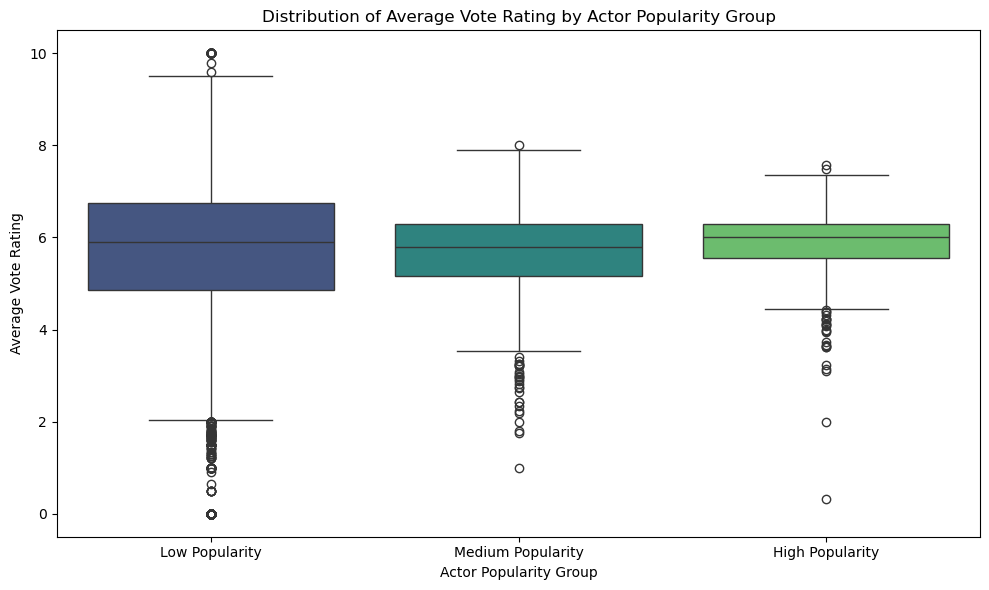

In [14]:
plt.figure(figsize=(10,6))

sns.boxplot(
    data=actor_summary,
    x='popularity_group',
    y='vote_average_mean',
    palette='viridis'
)

plt.title('Distribution of Average Vote Rating by Actor Popularity Group')
plt.xlabel('Actor Popularity Group')
plt.ylabel('Average Vote Rating')
plt.tight_layout()
plt.show()

We grouped actors into popularity tiers based on the number of movies they appeared in: High Popularity (10+ movies), Medium Popularity (5–9 movies), and Low Popularity (fewer than 5 movies). This produced group sizes of 745 high-popularity actors, 1,148 medium-popularity actors, and 16,488 low-popularity actors. The boxplot shows that, while differences are modest, high-popularity actors tend to appear in slightly better-rated films on average, with a higher median vote score and fewer extreme low-rating outliers. Low-popularity actors show the widest spread, indicating more variability in film quality for performers with limited filmographies.


#### **Linguistic Influence:** How does the original language of a film affect its average rating?

In [15]:
df_lang = df.dropna(subset=['original_language'])

language_summary = (
    df_lang.groupby('original_language')
           .agg(
               vote_average_mean=('vote_average', 'mean'),
               movie_count=('movie_id', 'count')
           )
           .reset_index()
           .sort_values('movie_count', ascending=False)
)

language_summary

original_language  vote_average_mean  movie_count
17                en           5.483561        32937
24                fr           6.038867         2524
34                it           5.437061         1565
36                ja           6.246300         1420
15                de           5.846445         1111
..               ...                ...          ...
25                fy           0.000000            1
18                eo           4.300000            1
13                cy           6.500000            1
4                 ay           6.000000            1
88                zu           8.300000            1

[89 rows x 3 columns]

In [16]:
# Filter for languages with at least 500 movies
lang_big = language_summary[language_summary['movie_count'] >= 500]

lang_big

original_language  vote_average_mean  movie_count
17                en           5.483561        32937
24                fr           6.038867         2524
34                it           5.437061         1565
36                ja           6.246300         1420
15                de           5.846445         1111
19                es           5.686076         1027
65                ru           5.702151          837
28                hi           5.794747          533

In [17]:
# Language code → full name mapping
lang_map = {
    'en': 'English',
    'fr': 'French',
    'it': 'Italian',
    'ja': 'Japanese',
    'de': 'German',
    'ru': 'Russian',
    'hi': 'Hindi'
}

# Apply mapping (fallback: keep code if not mapped)
df_lang_big['language_full'] = df_lang_big['original_language'].map(lang_map)

NameError: name 'df_lang_big' is not defined

/var/folders/jd/kgmmf40n35d3bhgwcsrqn78r0000gn/T/ipykernel_25188/1945161644.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


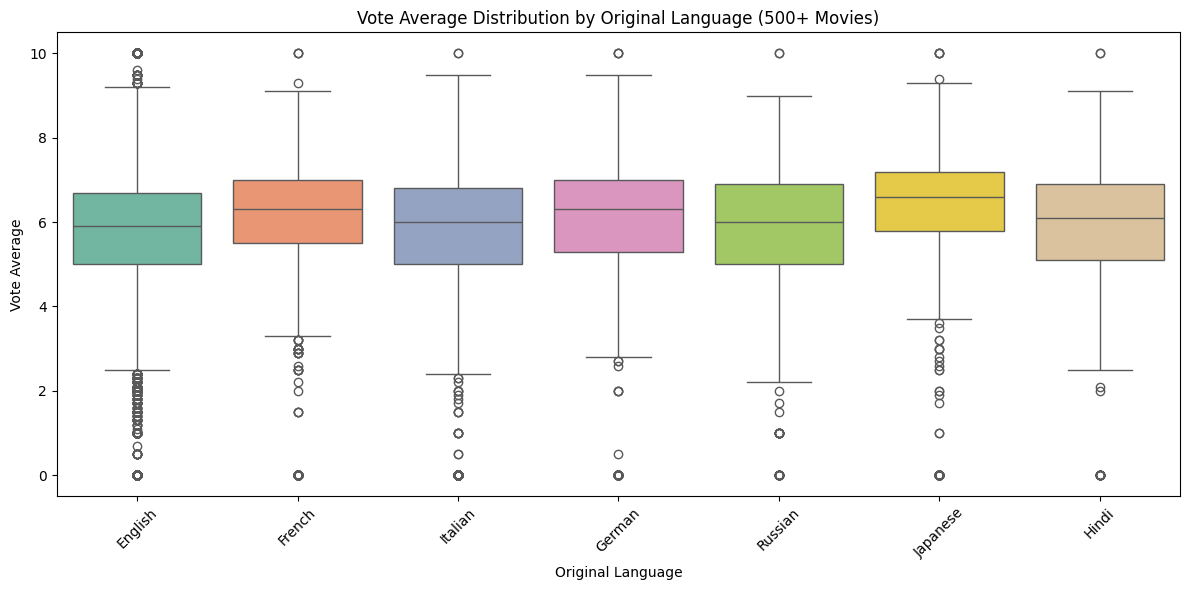

In [ ]:
plt.figure(figsize=(12,6))

sns.boxplot(
    data=df_lang_big,
    x='language_full',
    y='vote_average',
    palette='Set2'
)

plt.title('Vote Average Distribution by Original Language (500+ Movies)')
plt.xlabel('Original Language')
plt.ylabel('Vote Average')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

To analyze language effects, we restricted the dataset to languages with at least 500 films and created a cleaned classification that mapped language codes to their full names. The resulting visualization shows clear differences in average ratings across linguistic groups. Japanese and French films tend to receive noticeably higher vote averages, with medians above most other languages and tighter clustering among higher ratings. English films dominate the dataset numerically but show a broader distribution with many lower-rated entries, which lowers their overall median. German, Italian, Russian, and Hindi films fall in a middle band, each showing moderate central ratings but differing in the spread of outliers. These patterns likely reflect differences in film volume, cultural rating tendencies, and variation in production styles across regions.


#### **Adult Films:** Does the status of a film as 'adult' impact its average rating? 

In [ ]:
df_adult = df.dropna(subset=['adult'])

adult_summary = (
    df_adult
        .groupby('adult')
        .agg(
            vote_average_mean = ('vote_average', 'mean'),
            movie_count       = ('movie_id', 'count')
        )
        .reset_index()
)

adult_summary

adult  vote_average_mean  movie_count
0  False           5.611934        46620
1   True           3.922222            9

/var/folders/jd/kgmmf40n35d3bhgwcsrqn78r0000gn/T/ipykernel_25188/1349330158.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


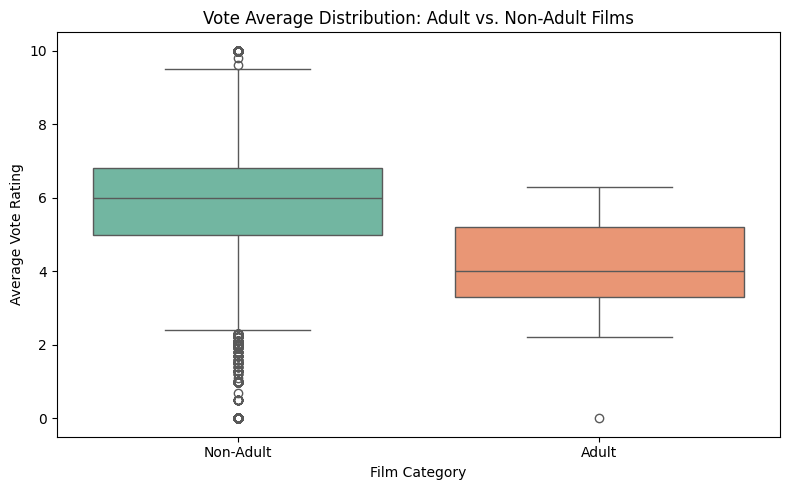

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df_adult,
    x='adult',
    y='vote_average',
    palette='Set2'
)

plt.xticks([0,1], ['Non-Adult', 'Adult'])
plt.xlabel('Film Category')
plt.ylabel('Average Vote Rating')
plt.title('Vote Average Distribution: Adult vs. Non-Adult Films')
plt.tight_layout()
plt.show()

We compared vote averages between adult and non-adult films by grouping titles using the dataset’s adult indicator. Non-adult movies make up nearly the entire dataset, while adult films account for only nine titles, which limits interpretability but still reveals a clear pattern. Adult-rated films show noticeably lower average ratings and a compressed distribution, while non-adult films span a wider range and have a higher median rating. This suggests that adult films tend to receive less favorable audience evaluations overall.

### Numerical Variables

Up to this point, we've been looking at the impact of various categorical variables on average rating.

Now we will look at some numerical variables as well.

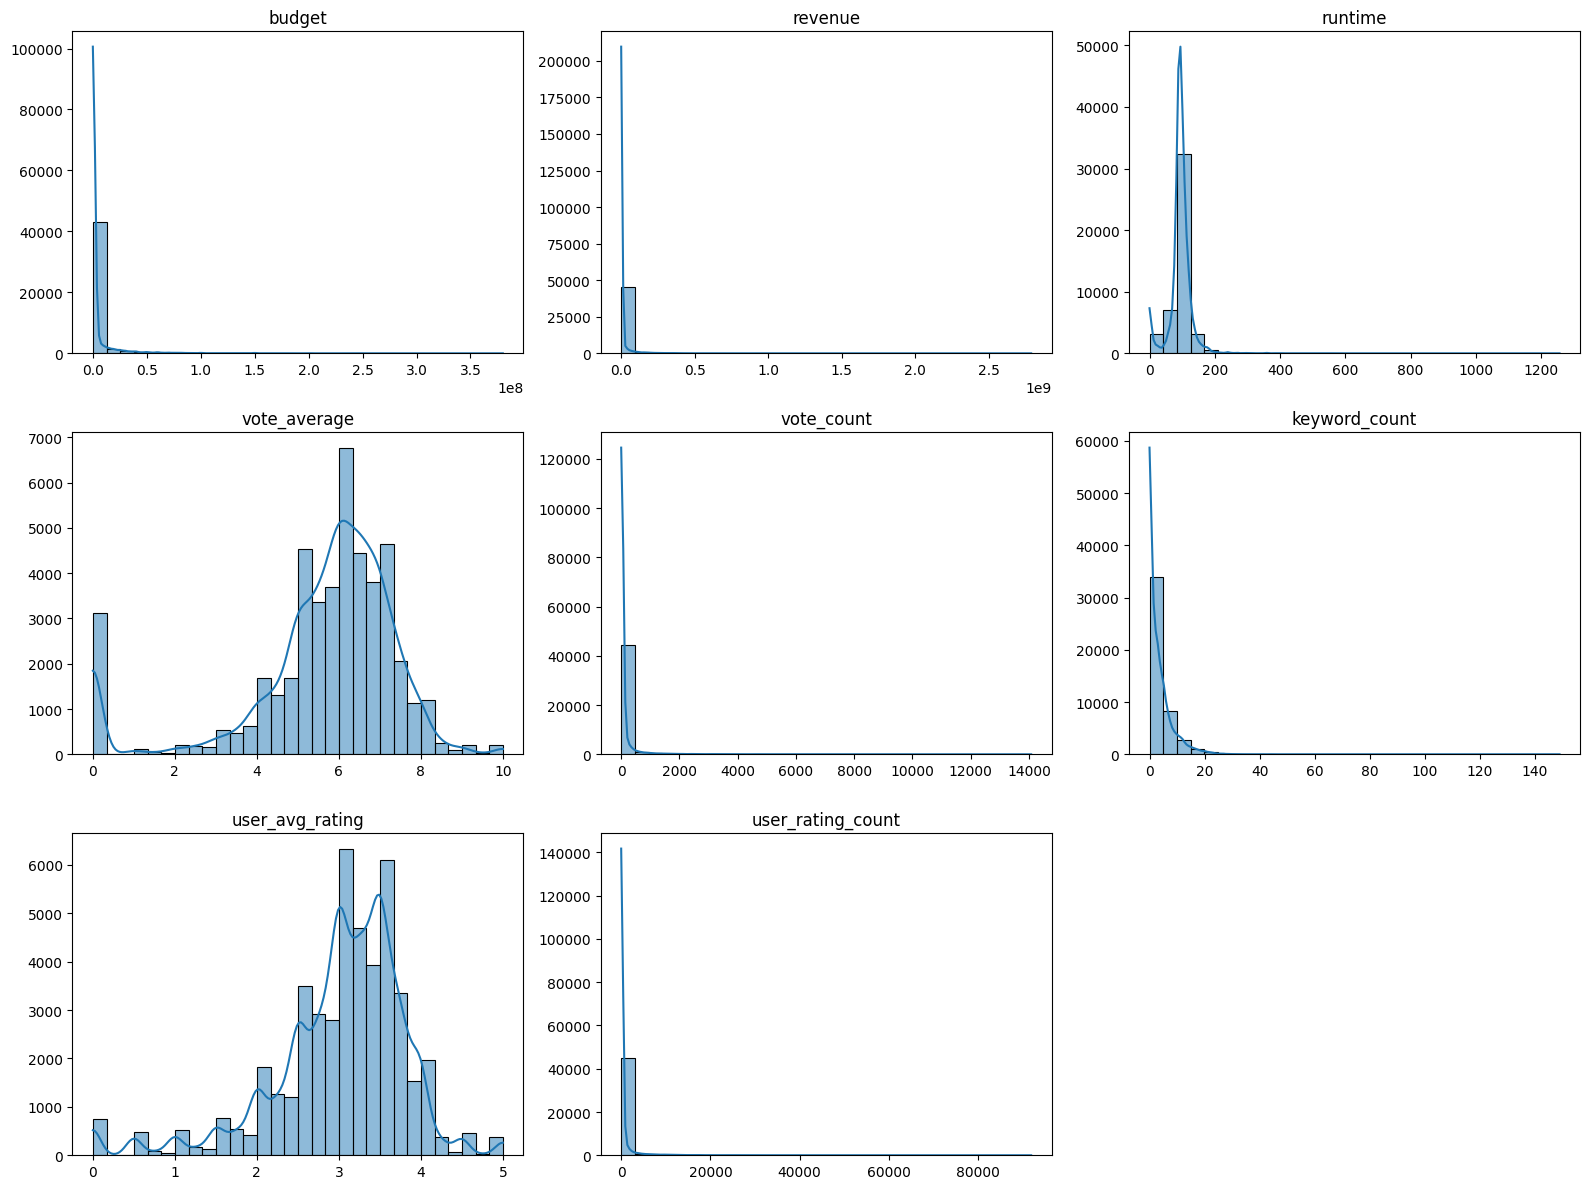

In [ ]:
df = df.dropna(subset=['vote_average', 'vote_count'])

df['user_avg_rating'] = df['user_avg_rating'].fillna(0)
df['user_rating_count'] = df['user_rating_count'].fillna(0)

df['runtime'] = df['runtime'].fillna(df['runtime'].median())



numeric_vars = [
    'budget', 'revenue', 'runtime', 'vote_average',
    'vote_count', 'keyword_count', 'user_avg_rating',
    'user_rating_count'
]

plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_vars, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

We first removed rows missing vote_average or vote_count, since these variables are essential for our analysis and only a very small number of records were affected. For user rating fields (user_avg_rating and user_rating_count), missing values were imputed with zero, which reflects the meaningful condition that a movie has no user ratings rather than a missing measurement. For runtime, which had more missing entries, we imputed using the median runtime to preserve the overall distribution without being overly influenced by extreme runtimes. All other fields were left unchanged because they were either categorical, sparsely missing, or not required for numeric visualization.

Most numerical variables exhibit strong right skew, including budget, revenue, vote_count, keyword_count, and user_rating_count, where the majority of values are low with a long tail of very large values. Runtime is also right skewed but with a more compact range. In contrast, vote_average and user_avg_rating are approximately bell shaped, showing symmetric distributions centered around their typical rating values. These patterns are consistent with movie industry data where a small number of films accumulate very high budgets, revenues, or rating counts.

We will apply log transformation to the following variables to reduce extreme skew and improve interpretability in later modeling:
- budget
- revenue
- vote_count
- keyword_count
- user_rating_count

These variables span several orders of magnitude, and the log transform will compress their long right tails, stabilize variance, and make relationships more linear and more suitable for regression or clustering. Runtime, vote_average, and user_avg_rating do not require log transformation because their distributions are already well behaved.


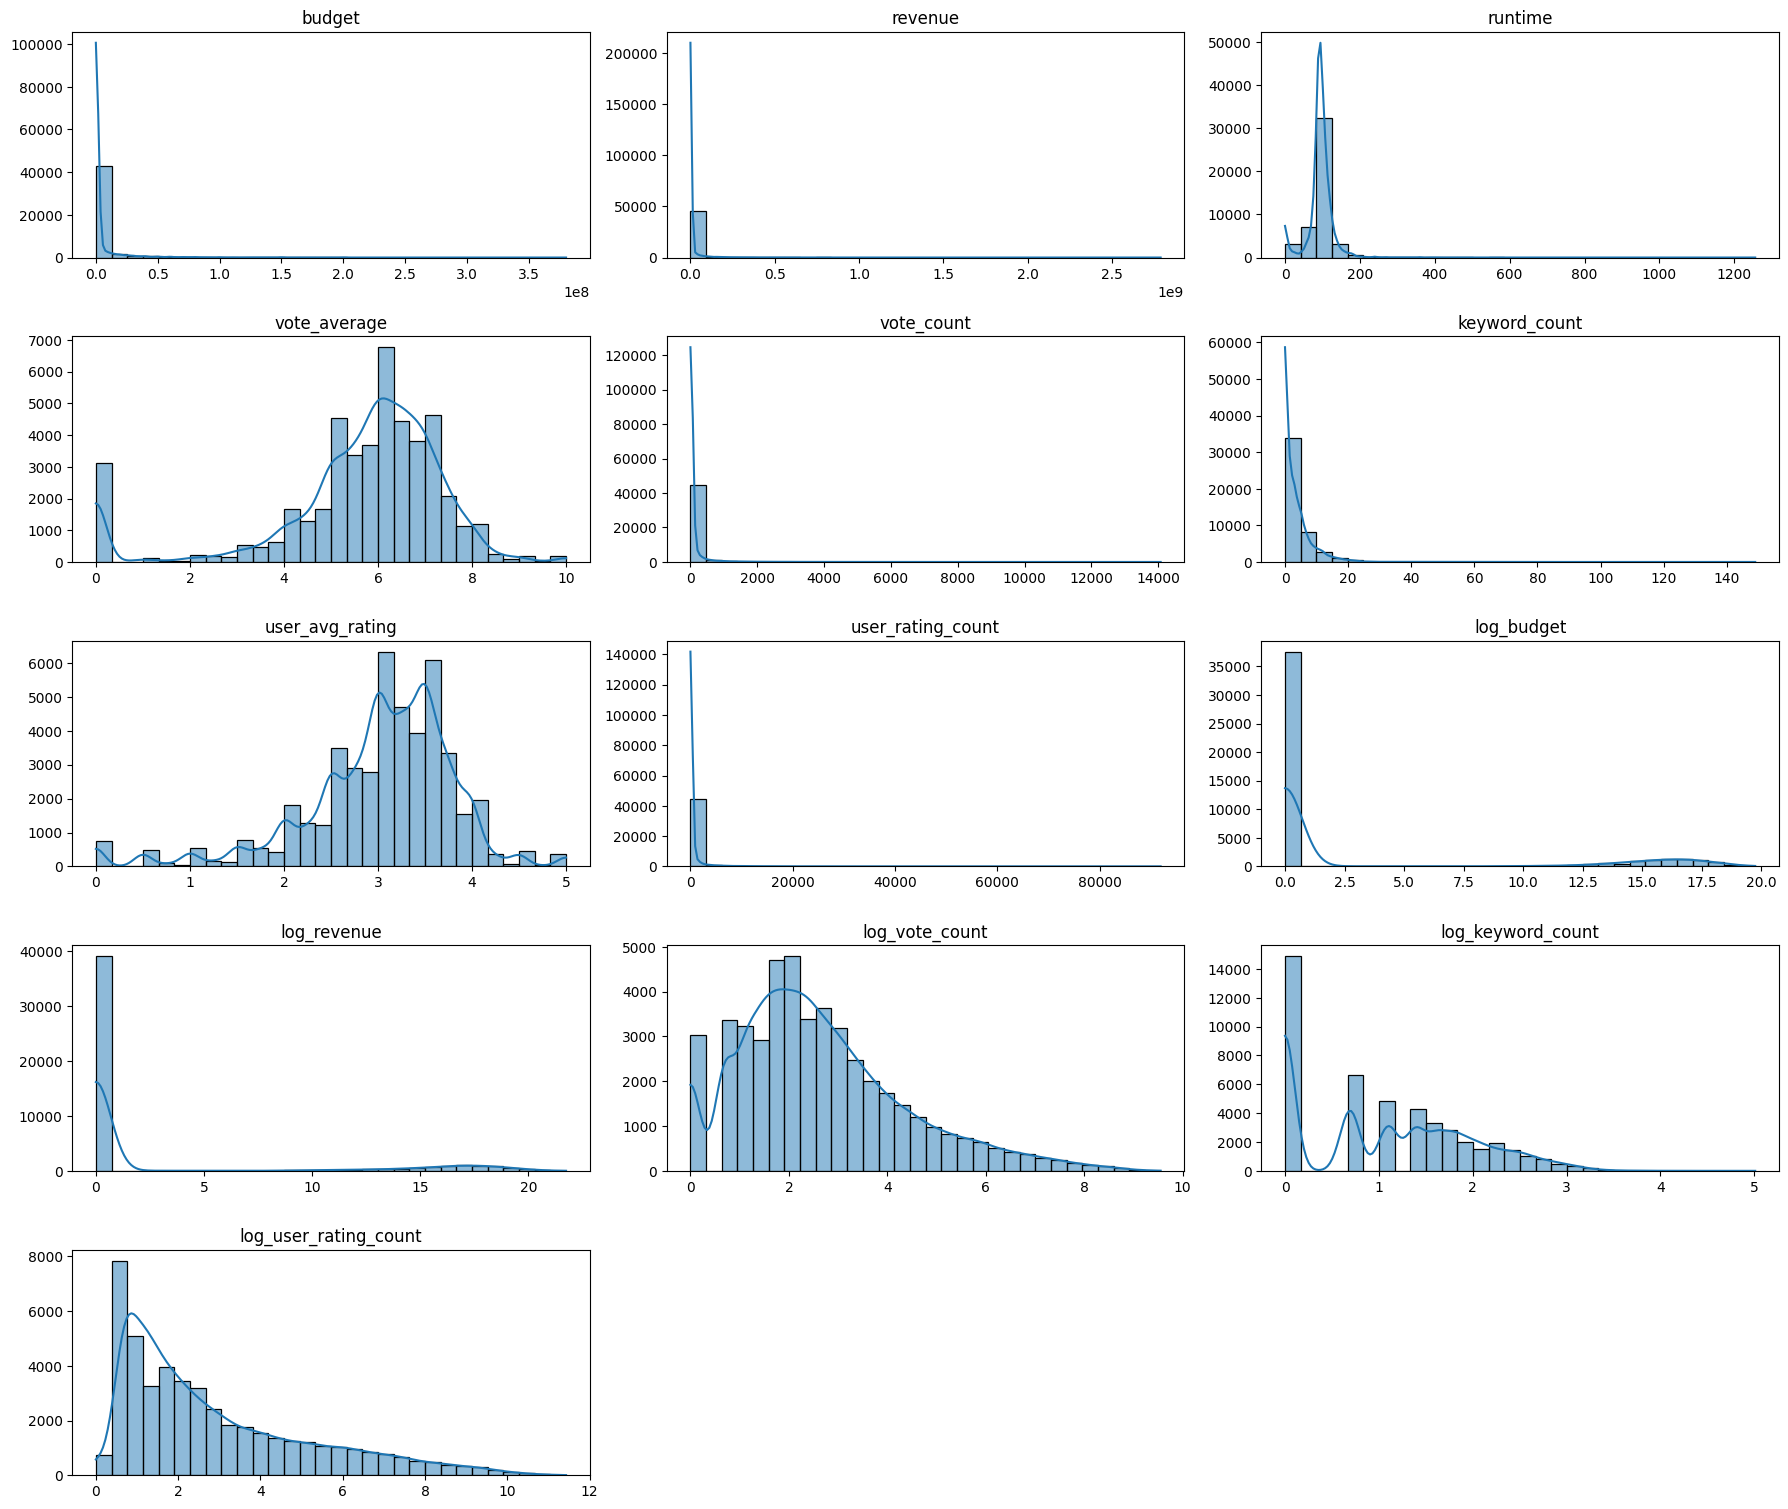

In [ ]:
import numpy as np

log_vars = [
    'budget', 'revenue', 'vote_count',
    'keyword_count', 'user_rating_count'
]

# Create log-transformed versions (using log1p to handle zeros)
for col in log_vars:
    df[f'log_{col}'] = np.log1p(df[col])

# Re-visualize numerical variables including log versions
numeric_vars = [
    'budget', 'revenue', 'runtime', 'vote_average',
    'vote_count', 'keyword_count', 'user_avg_rating',
    'user_rating_count',
    'log_budget', 'log_revenue', 'log_vote_count',
    'log_keyword_count', 'log_user_rating_count'
]

plt.figure(figsize=(18, 18))

for i, col in enumerate(numeric_vars, 1):
    plt.subplot(6, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

The log transformations substantially improved the distributions of the most skewed numerical variables. Budget, revenue, vote_count, keyword_count, and user_rating_count all shifted from extreme right skew with long tails to much more compact and interpretable shapes after applying log1p. While these transformed variables are not perfectly normal, they now show smoother, more symmetric distributions with compressed outliers, making them far better suited for correlation analysis and modeling. The normally distributed variables, such as vote_average and user_avg_rating, remained unchanged, and runtime continues to show a reasonable distribution without transformation. Overall, the dataset is now far more balanced and appropriate for downstream statistical or machine learning tasks.

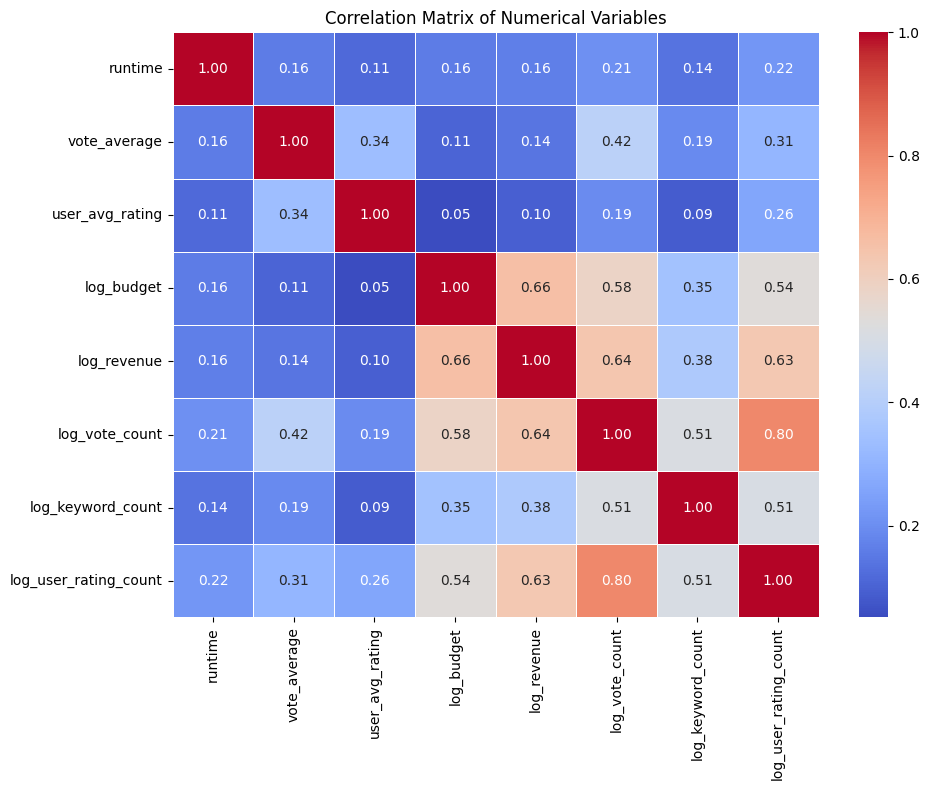

In [ ]:
# Select numerical variables for correlation
corr_vars = [
    'runtime',
    'vote_average',
    'user_avg_rating',
    'log_budget',
    'log_revenue',
    'log_vote_count',
    'log_keyword_count',
    'log_user_rating_count'
]

corr_matrix = df[corr_vars].corr()

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

The correlation matrix shows a few clear and intuitive relationships among the numerical variables. The strongest correlations appear among the popularity-related measures: log_vote_count and log_user_rating_count have a very high correlation (0.80), indicating that movies receiving more votes on TMDB also tend to receive more user ratings across platforms. Log_revenue is also strongly correlated with both log_vote_count (0.64) and log_user_rating_count (0.63), suggesting that commercially successful films tend to have larger audiences and thus accumulate more user engagement. Log_budget shows moderate correlation with revenue (0.66) and vote_count (0.58), which aligns with expectations that higher-budget films typically receive more attention and generate more earnings.

On the other hand, vote_average and user_avg_rating, which reflect quality perception, have relatively weak correlations with the other variables. Vote_average correlates only modestly with vote_count (0.42) and user_rating_count (0.31), meaning popular movies are not necessarily higher-rated. Runtime also shows weak associations with all variables, suggesting film length does not meaningfully predict popularity or perceived quality. Overall, the main relationships cluster around popularity and audience engagement rather than rating metrics, highlighting that commercial reach and public perception behave differently from measured film quality.

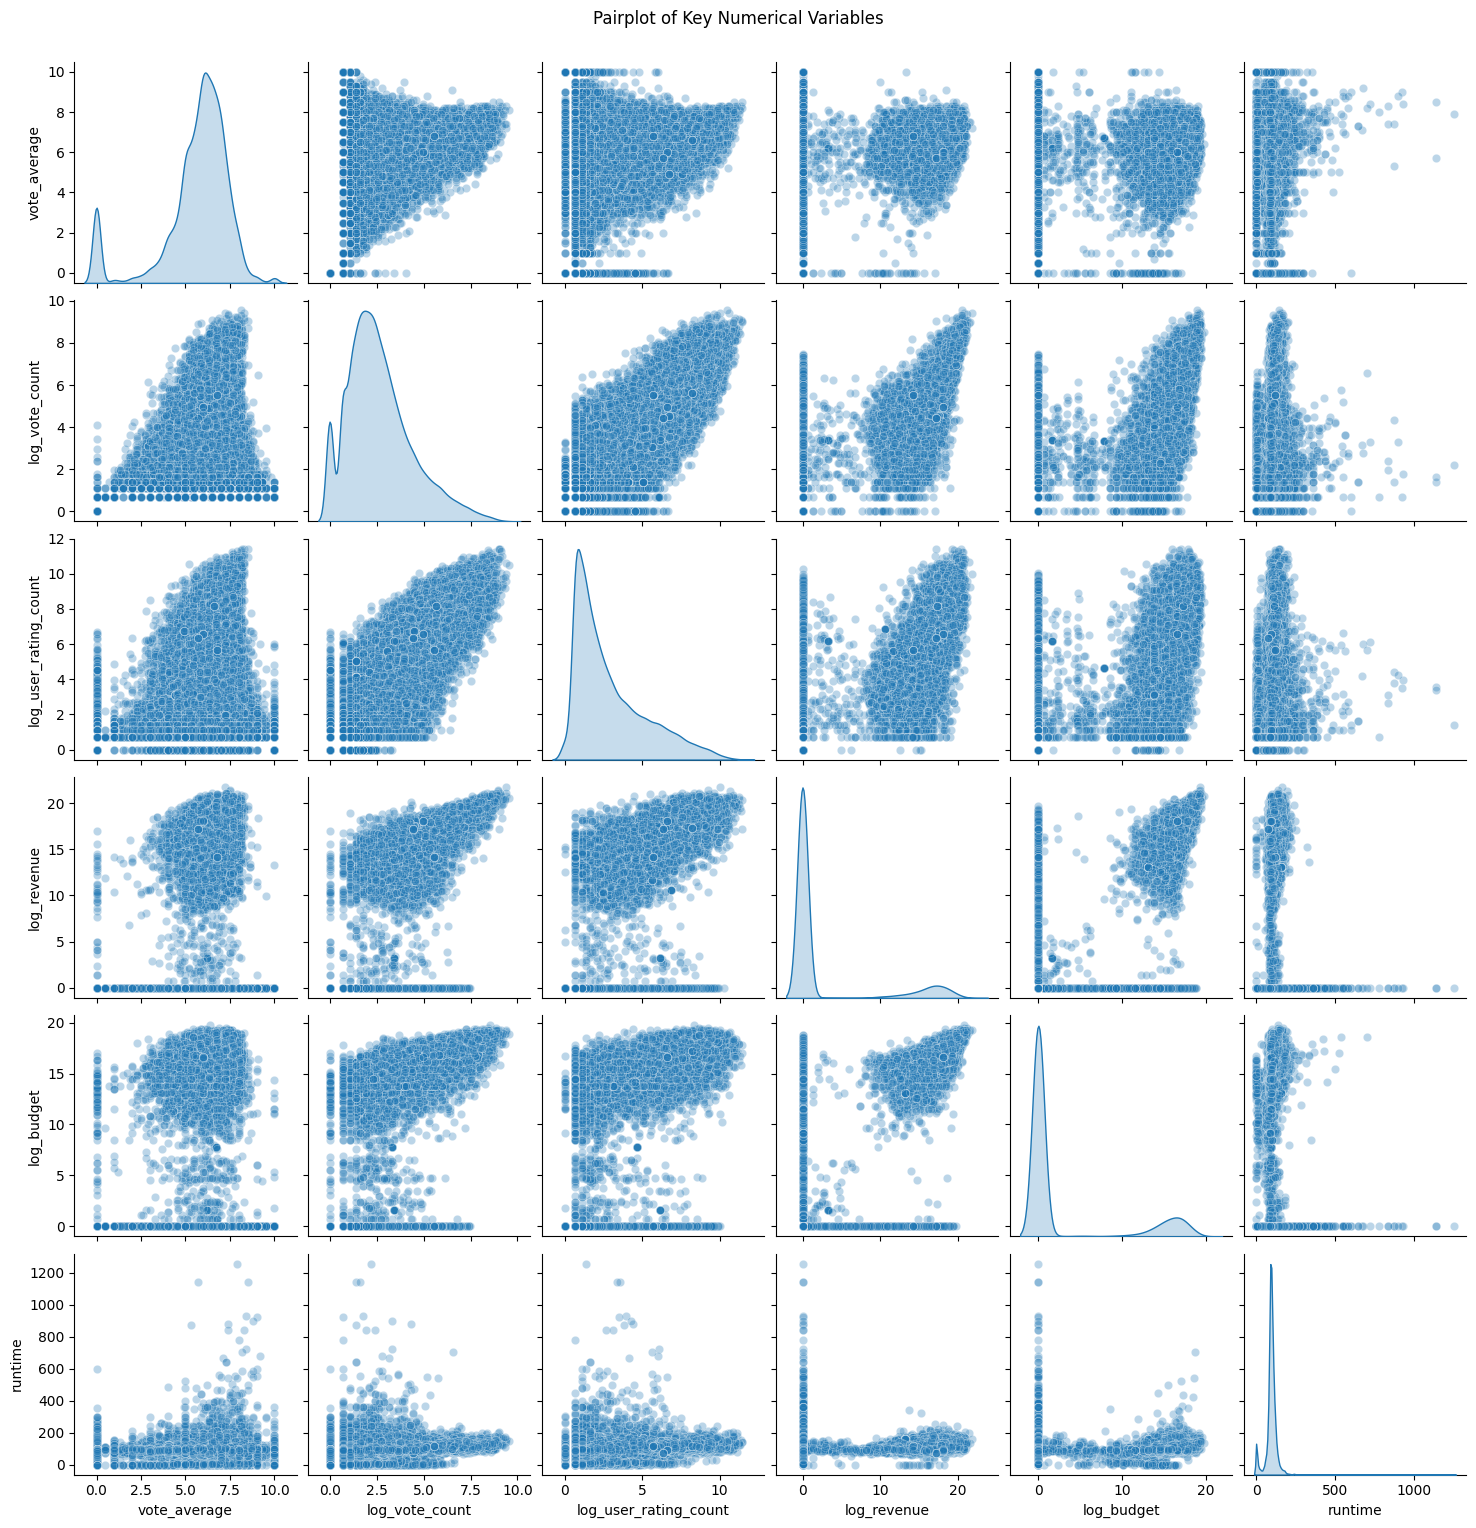

In [ ]:
pairplot_vars = [
    'vote_average',
    'log_vote_count',
    'log_user_rating_count',
    'log_revenue',
    'log_budget',
    'runtime'
]

sns.pairplot(
    df[pairplot_vars],
    diag_kind='kde',
    plot_kws={'alpha': 0.3}
)
plt.suptitle("Pairplot of Key Numerical Variables", y=1.02)
plt.show()

The pairplot highlights the relationships between the main numerical predictors after log transformation. Most scatterplots remain diffuse with no strong linear patterns, but a few trends stand out. Log vote count, log user rating count, and log revenue all show mild positive relationships with each other, which is expected given they reflect audience engagement and popularity. Runtime shows little structured association with the log-scaled variables, though a slight upward trend appears with vote average. Overall, the pairplot supports the idea that popularity metrics are interrelated, while budget and runtime behave more independently.


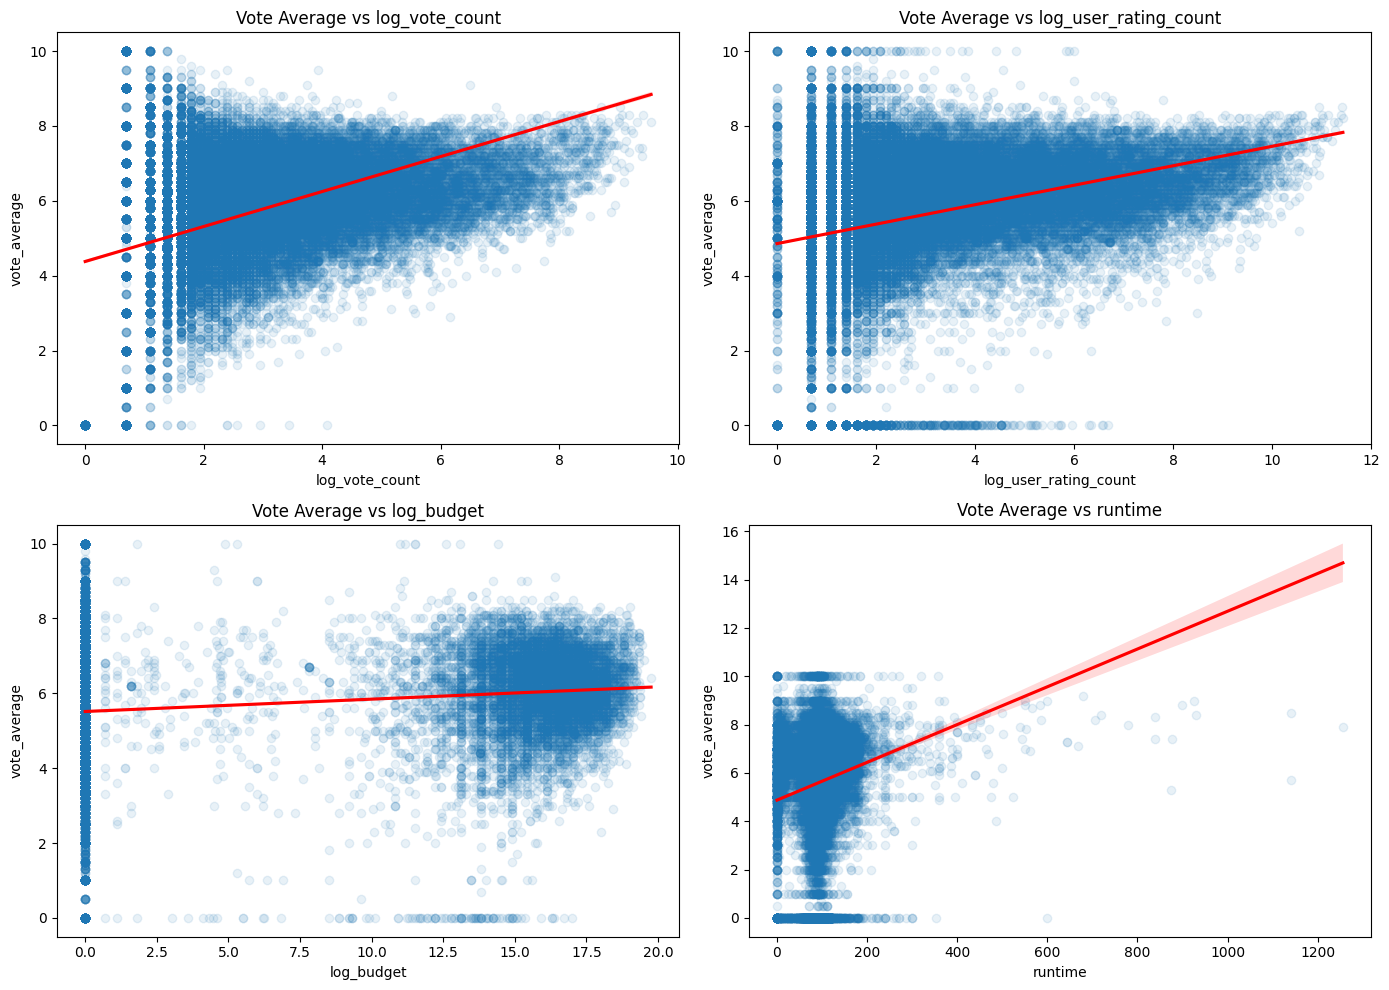

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

predictors = [
    'log_vote_count',
    'log_user_rating_count',
    'log_budget',
    'runtime'
]

for ax, var in zip(axes.flatten(), predictors):
    sns.regplot(
        data=df,
        x=var,
        y='vote_average',
        scatter_kws={'alpha':0.1},
        line_kws={'color':'red'},
        ax=ax
    )
    ax.set_title(f'Vote Average vs {var}')

plt.tight_layout()
plt.show()

These regression plots show how vote average changes with each selected predictor. Log vote count has the clearest positive relationship, suggesting that movies that attract more votes tend to receive higher average ratings. Log user rating count shows a similar, though weaker, upward trend. Log budget displays only a slight positive slope, implying that higher-budget films may perform marginally better on average but with substantial variability. Runtime shows a moderate positive trend, driven partly by a cluster of long-duration films with higher ratings. Overall, popularity variables relate more strongly to vote average than production-related variables.


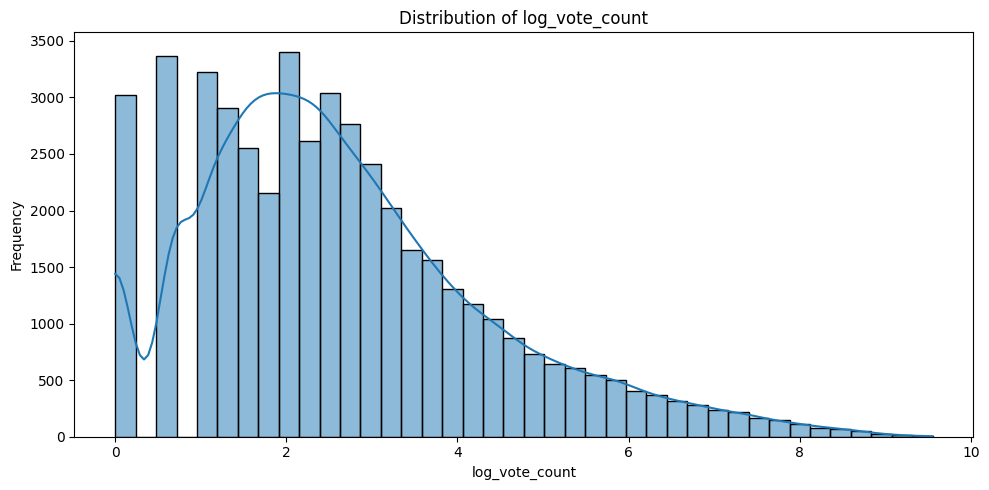

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['log_vote_count'], kde=True, bins=40)
plt.title('Distribution of log_vote_count')
plt.xlabel('log_vote_count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The log-transformed vote count displays a right-skewed but far more normalized distribution than the original scale. Most films fall between log values of 1 and 4, representing modest levels of audience engagement, while only a small subset reaches the higher end of the scale. This distribution indicates that a few widely seen films dominate overall voting activity, while the majority receive limited attention. The KDE curve smooths this pattern and confirms that the log transformation makes the variable more suitable for modeling.


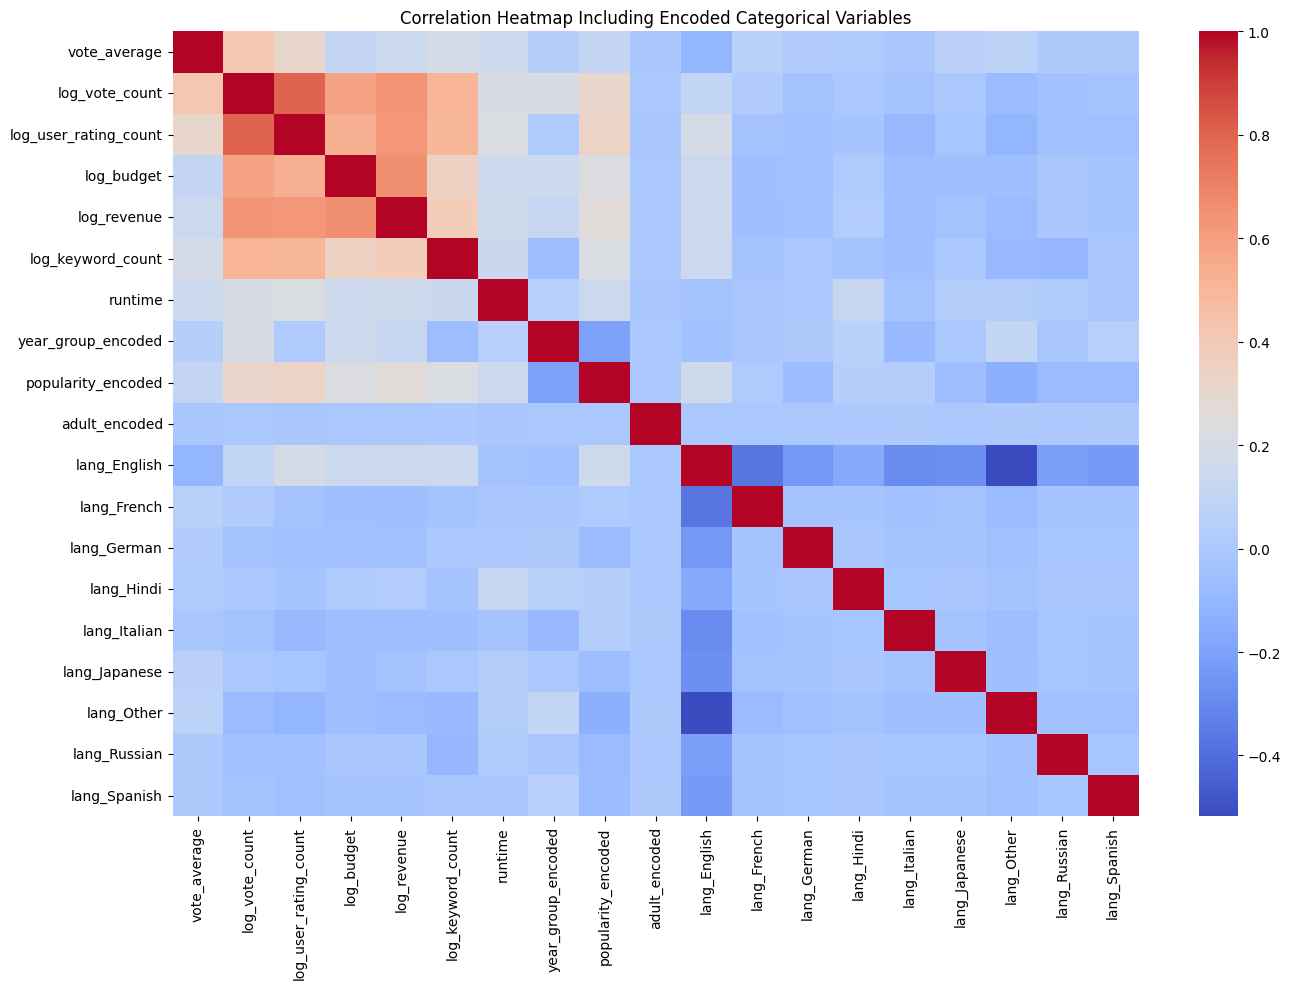

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
df_corr = df.copy()

# Create ordered year groups
df_corr['year_group'] = pd.cut(df_corr['release_year'],
    bins=[0,1919,1949,1979,1999,2009,2019],
    labels=['Pre-1920','1920–1949','1950–1979','1980–1999','2000–2009','2010–2019']
)

# Fill missing year groups with Unknown
df_corr['year_group'] = df_corr['year_group'].astype('object').fillna('Unknown')

# Define full year order including Unknown
year_order = ['Unknown','Pre-1920','1920–1949','1950–1979','1980–1999','2000–2009','2010–2019']

# Build actor popularity groups
df_actor = df_corr.groupby('lead_actor').agg(movie_count=('movie_id','count')).reset_index()

# Function for classifying popularity
def classify_pop(count):
    if count >= 10:
        return 'High Popularity'
    elif count >= 5:
        return 'Medium Popularity'
    else:
        return 'Low Popularity'

# Apply popularity classification
df_actor['popularity_group'] = df_actor['movie_count'].apply(classify_pop)

# Merge popularity group back to df
df_corr = df_corr.merge(df_actor[['lead_actor','popularity_group']], on='lead_actor', how='left')

# Fill missing popularity with Low Popularity
df_corr['popularity_group'] = df_corr['popularity_group'].fillna('Low Popularity')

# Define popularity order
pop_order = ['Low Popularity','Medium Popularity','High Popularity']

# Map languages to simplified names
language_map = {'en':'English','fr':'French','it':'Italian','ja':'Japanese','de':'German','es':'Spanish','ru':'Russian','hi':'Hindi'}

# Apply language mapping
df_corr['language_name'] = df_corr['original_language'].map(language_map).fillna('Other')

# Create log transformed numerical variables
df_corr['log_budget'] = np.log1p(df_corr['budget'])
df_corr['log_revenue'] = np.log1p(df_corr['revenue'])
df_corr['log_vote_count'] = np.log1p(df_corr['vote_count'])
df_corr['log_user_rating_count'] = np.log1p(df_corr['user_rating_count'])
df_corr['log_keyword_count'] = np.log1p(df_corr['keyword_count'])

# Ordinal encode year groups
enc_year = OrdinalEncoder(categories=[year_order], handle_unknown='use_encoded_value', unknown_value=-1)
df_corr['year_group_encoded'] = enc_year.fit_transform(df_corr[['year_group']])

# Ordinal encode popularity groups
enc_pop = OrdinalEncoder(categories=[pop_order], handle_unknown='use_encoded_value', unknown_value=-1)
df_corr['popularity_encoded'] = enc_pop.fit_transform(df_corr[['popularity_group']])

# One hot encode language names
language_dummies = pd.get_dummies(df_corr['language_name'], prefix='lang')

# Convert adult to numeric flag
df_corr['adult_encoded'] = df_corr['adult'].astype(int)

# Select numeric variables
num_vars = ['vote_average','log_vote_count','log_user_rating_count','log_budget','log_revenue','log_keyword_count','runtime']

# Select encoded categorical variables
encoded_vars = ['year_group_encoded','popularity_encoded','adult_encoded']

# Build final correlation dataframe
corr_df = pd.concat([df_corr[num_vars], df_corr[encoded_vars], language_dummies], axis=1)

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(corr_df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap Including Encoded Categorical Variables')
plt.tight_layout()
plt.show()

The encoded correlation heatmap shows that the strongest relationships occur among the numerical predictors, with log_vote_count, log_user_rating_count, log_budget, and log_revenue forming a clear cluster that reflects movie popularity and commercial success. These variables also show modest positive correlations with vote_average, meaning more widely viewed or higher budget films tend to receive slightly higher ratings. The ordinal encodings behave as expected: actor popularity correlates moderately with vote and rating counts, year group has only weak associations with all variables, and the adult flag shows virtually no meaningful relationship with anything. Language dummy variables exhibit only small correlations, indicating that language does not strongly drive numeric patterns, although a few languages show slightly higher average ratings. Overall, the heatmap suggests that popularity related numeric features will be the most influential predictors in modeling, while categorical encodings contribute weaker but still meaningful supplementary structure.

## Operating on non-zero budgets - We will model based on this

In [ ]:
budget_nonzero = df.loc[df['budget'] > 0, 'budget']

budget_nonzero.quantile([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

0.01    1.000000e+01
0.05    4.500000e+04
0.10    3.000000e+05
0.25    2.000000e+06
0.50    8.000000e+06
0.75    2.500000e+07
0.90    6.000000e+07
0.95    8.880000e+07
0.99    1.700000e+08
Name: budget, dtype: float64

In [ ]:
budget_nonzero_count = budget_nonzero.shape[0]
budget_nonzero_count

9053

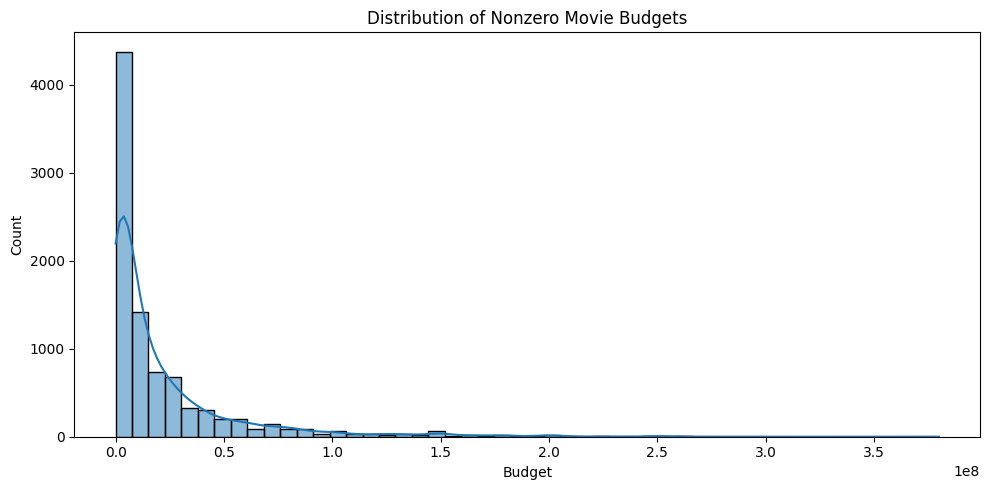

In [ ]:
budget_nonzero = df.loc[df['budget'] > 0, 'budget']

plt.figure(figsize=(10,5))
sns.histplot(budget_nonzero, bins=50, kde=True)
plt.title("Distribution of Nonzero Movie Budgets")
plt.xlabel("Budget")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

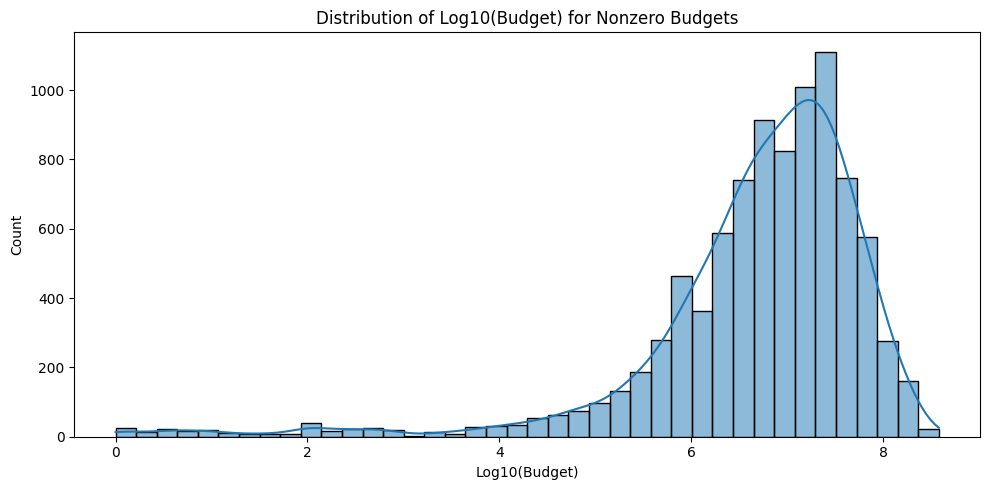

In [ ]:
log_budget = np.log10(budget_nonzero)

plt.figure(figsize=(10,5))
sns.histplot(log_budget, bins=40, kde=True)
plt.title("Distribution of Log10(Budget) for Nonzero Budgets")
plt.xlabel("Log10(Budget)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The nonzero budget distribution shows that movie spending is extremely right skewed, with most films made on relatively small budgets and a long tail of very expensive productions. The percentile table confirms this: half of all budgeted movies report budgets under 4 million dollars and even the 90th percentile is only about 25 million dollars, while the top 1 percent reaches 100 million dollars or more. After applying a log transformation, the distribution becomes much closer to a smooth, unimodal shape, centered around log10(budget) values between 6 and 7, which corresponds to budgets in the 1 to 10 million dollar range. The transformation effectively spreads out the dense mass of small budgets and compresses the extreme values, giving a much more interpretable and modeling friendly view of budget behavior.

In [ ]:
# Summary of all languages with nonzero budgets, sorted by count only
lang_summary_all = (
    df_nz
        .groupby('original_language')
        .agg(
            movie_count=('movie_id', 'count')
        )
        .reset_index()
        .sort_values('movie_count', ascending=False)
)

lang_summary_all

original_language  movie_count
12                en         7535
17                fr          248
40                ru          141
19                hi          139
13                es          119
10                de           98
24                ja           92
23                it           85
26                ko           68
53                zh           67
16                fi           66
9                 da           37
38                pt           34
45                ta           34
7                 cn           33
34                nl           29
44                sv           28
35                no           23
36                pl           19
47                th           17
31                ml           15
43                sr           13
18                he           11
46                te           11
48                tr           10
15                fa           10
39                ro            9
20                hu            7
14                et            5
21                id            4
11                el            4
49                uk            3
41                sl            3
50                ur            3
22                is            3
8                 cs            3
32                mr            3
6                 ca            2
30                lv            2
29                lo            2
51                vi            2
1                 ar            2
52                xx            2
33                nb            2
0                 af            1
42                sq            1
37                ps            1
28                la            1
25                kn            1
5                 bs            1
4                 bo            1
3                 bm            1
2                 bg            1
27                ku            1

In [ ]:
# Count languages
lang_counts = df_nz['original_language'].value_counts()

# Languages with at least 80 films
valid_langs_80 = lang_counts[lang_counts >= 80].index

# Create a new column with Other for smaller groups
df_nz['language_group'] = df_nz['original_language'].apply(
    lambda x: x if x in valid_langs_80 else 'Other'
)

# Summary
df_nz['language_group'].value_counts()

language_group
en       7535
Other     596
fr        248
ru        141
hi        139
es        119
de         98
ja         92
it         85
Name: count, dtype: int64

In [ ]:
# Compute summary statistics for the new language groups
lang_group_summary = (
    df_nz
        .groupby('language_group')
        .agg(
            vote_average_mean=('vote_average', 'mean'),
            movie_count=('movie_id', 'count')
        )
        .reset_index()
        .sort_values('vote_average_mean', ascending=False)
)

lang_group_summary

language_group  vote_average_mean  movie_count
7             ja           6.556522           92
4             fr           6.402419          248
5             hi           6.384892          139
0          Other           6.285906          596
6             it           6.217647           85
3             es           6.167227          119
1             de           6.094898           98
2             en           5.963464         7535
8             ru           5.479433          141

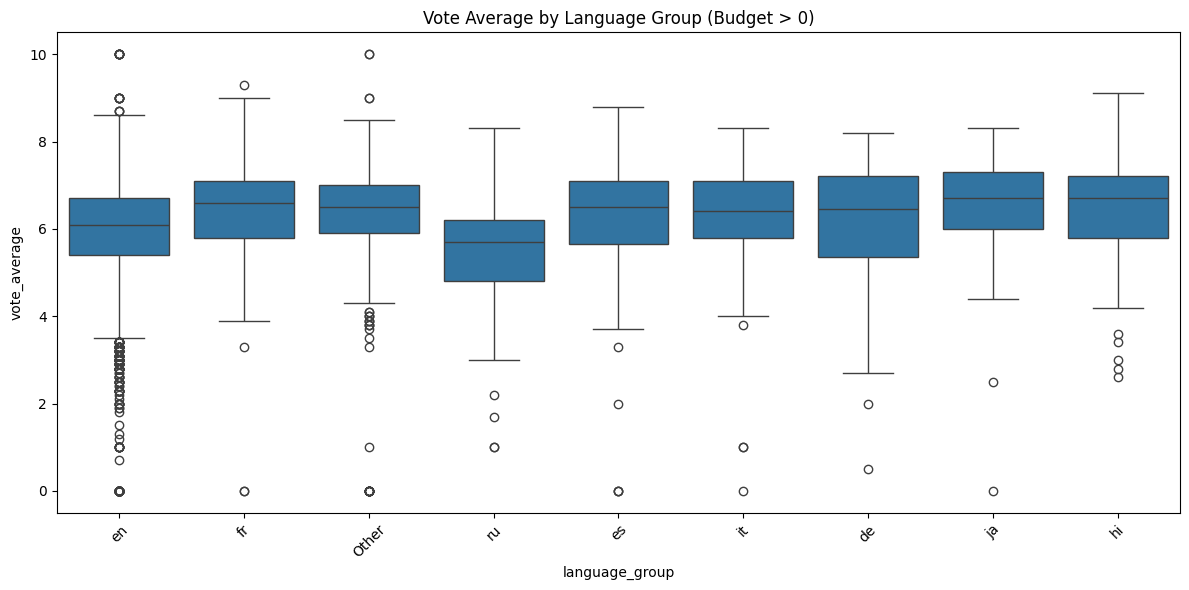

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_nz, x='language_group', y='vote_average')
plt.xticks(rotation=45)
plt.title('Vote Average by Language Group (Budget > 0)')
plt.tight_layout()
plt.show()

To create more meaningful comparisons after restricting the dataset to films with nonzero budgets, we regrouped languages based on representation. Languages with at least 80 films were kept as their own categories, while all others were combined into an Other group. This avoids unstable averages from very small samples and produces clearer boxplots.

The results show clear variation across language groups. Japanese films achieve the highest average rating at 6.56, followed by French and Hindi films, both above 6.38. The Other category also performs well, suggesting that many smaller-represented languages tend to produce moderately high-rated films. English, despite having the largest sample by far, shows a lower average rating of 5.96, likely due to the higher volume and diversity of mainstream commercial releases. Russian films have the lowest mean rating at 5.48. The boxplot reflects these patterns, with Japanese, French, and Hindi distributions shifted higher, while English and Russian films show more spread and lower central tendencies.

In [ ]:
# 1. Build genre-expanded dataset for nonzero budgets
df_genres_nz = (
    df_nz.assign(genre=df_nz['genres'].str.split('|'))
         .explode('genre')
)

# 2. Clean invalid genres
df_genres_nz = df_genres_nz.dropna(subset=['genre'])
df_genres_nz['genre'] = df_genres_nz['genre'].astype(str)

# 3. Summary table: mean vote + count
genre_summary_nz = (
    df_genres_nz
        .groupby('genre')
        .agg(
            vote_average_mean=('vote_average', 'mean'),
            movie_count=('movie_id', 'count')
        )
        .reset_index()
        .sort_values('vote_average_mean', ascending=False)
)

# 4. Display summary
genre_summary_nz

genre  vote_average_mean  movie_count
10          History           6.635641          390
18              War           6.613333          330
2         Animation           6.361818          440
6             Drama           6.317039         4255
12            Music           6.306369          314
19          Western           6.252817          142
4             Crime           6.234973         1281
14          Romance           6.191148         1525
13          Mystery           6.134046          655
1         Adventure           6.053561         1320
7            Family           5.985115          739
3            Comedy           5.966443         2837
8           Fantasy           5.958133          750
17         Thriller           5.890710         2422
0            Action           5.880028         2148
5       Documentary           5.864453          256
15  Science Fiction           5.732677         1016
9           Foreign           5.715873          126
11           Horror           5.423894         1289
16         TV Movie           5.031111           45

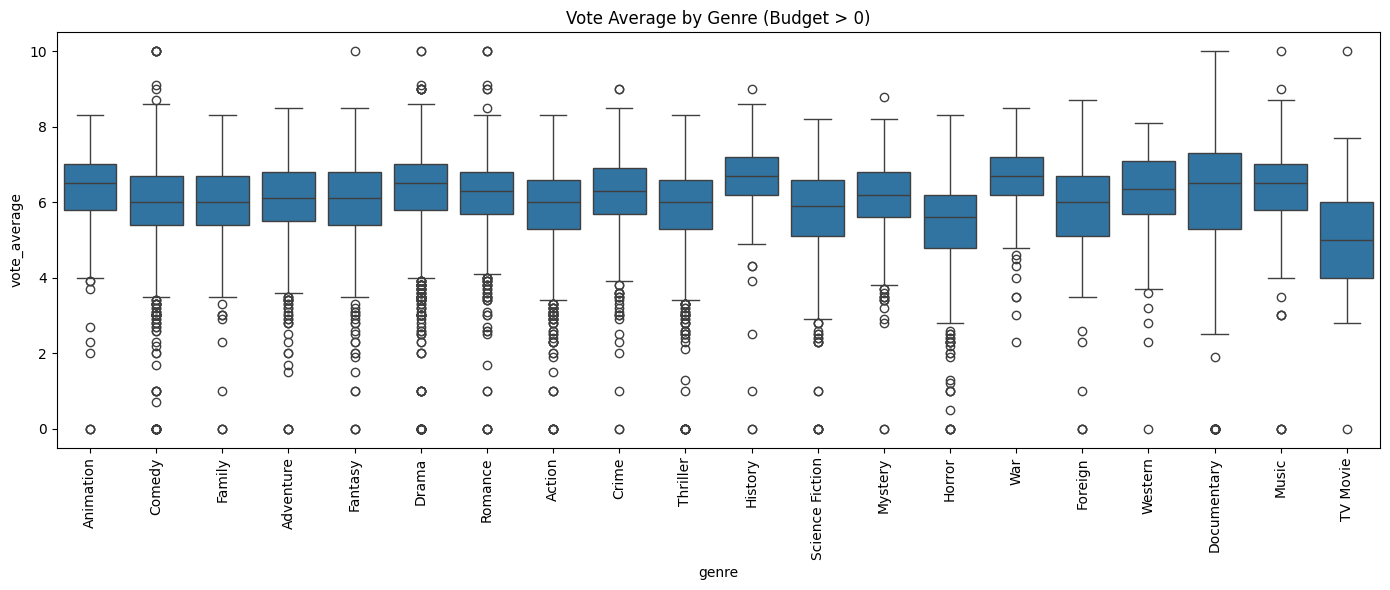

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_genres_nz, x='genre', y='vote_average')
plt.xticks(rotation=90)
plt.title('Vote Average by Genre (Budget > 0)')
plt.tight_layout()
plt.show()

After restricting the dataset to films with nonzero budgets, clear genre-level patterns begin to emerge. Genres such as History, War, and Animation show the strongest average ratings, each above 6.3, suggesting that audiences respond especially well to historically grounded stories, conflict driven narratives, and high quality animated films. Drama, Music, Crime, and Romance also perform consistently well across a wide range of movies, while genres like Horror, Foreign, and TV Movie receive noticeably lower ratings. The distribution within each genre remains fairly wide, which reflects high variability in audience reception, but the central tendencies show that some genres are more reliably associated with higher rated productions when studios invest real budgets.

In [ ]:
df_year_nz = df_nz.copy()

bins = [0, 1919, 1949, 1979, 1999, 2009, 2019]
labels = ['Pre-1920', '1920–1949', '1950–1979', '1980–1999', '2000–2009', '2010–2019']

df_year_nz['year_group'] = pd.cut(df_year_nz['release_year'], bins=bins, labels=labels, right=True)

year_summary_nz = (
    df_year_nz
        .groupby('year_group')
        .agg(
            vote_average_mean=('vote_average', 'mean'),
            movie_count=('movie_id', 'count')
        )
        .reset_index()
)
year_summary_nz

/var/folders/jd/kgmmf40n35d3bhgwcsrqn78r0000gn/T/ipykernel_25188/3142820361.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('year_group')


year_group  vote_average_mean  movie_count
0   Pre-1920           6.642857           14
1  1920–1949           6.659735          226
2  1950–1979           6.497739          752
3  1980–1999           6.115381         2061
4  2000–2009           5.879354         2940
5  2010–2019           5.894437         3056

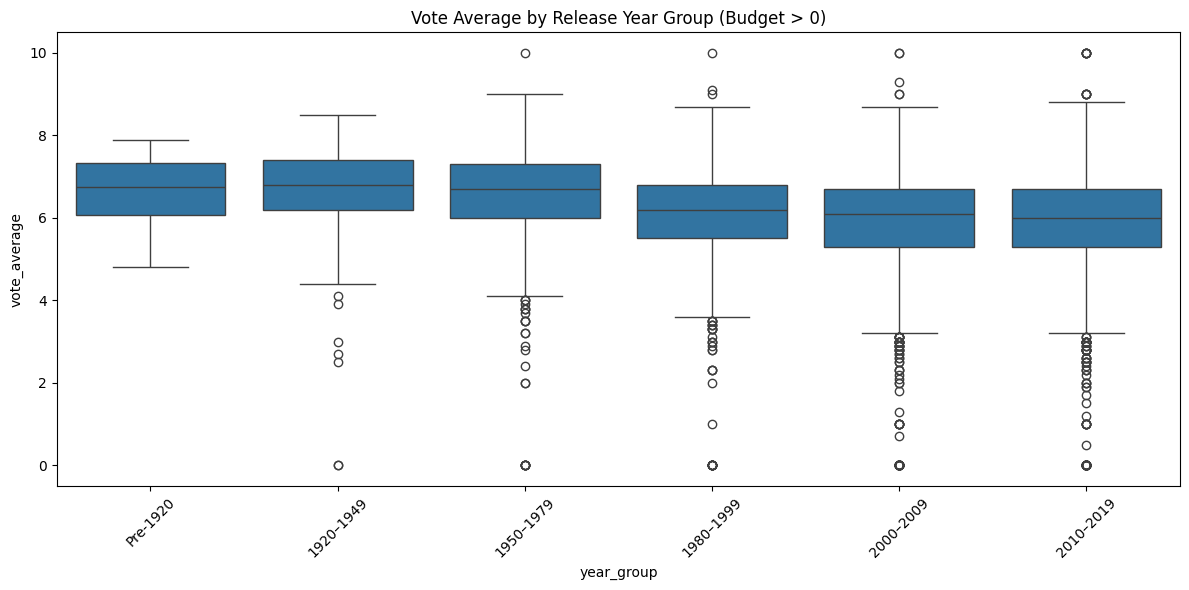

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_year_nz, x='year_group', y='vote_average')
plt.xticks(rotation=45)
plt.title('Vote Average by Release Year Group (Budget > 0)')
plt.tight_layout()
plt.show()

The distribution of ratings by release year shows a modest upward trend, with films from 2010 to 2019 earning the highest average vote scores. Mid century films from 1950 to 1979 also perform well, suggesting a strong reception for both contemporary and classic eras. Earlier periods, especially before 1950, show more variability and generally lower ratings, likely reflecting differences in production quality and audience expectations over time. Overall, once we restrict the dataset to movies with real production budgets, the pattern becomes clearer: newer films tend to receive slightly higher ratings on average.

In [ ]:
df_nz = df[df['budget'] > 0].copy()

# Build actor summary
actor_summary_nz = (
    df_nz.groupby('lead_actor')
         .agg(
             movie_count=('movie_id', 'count'),
             vote_average_mean=('vote_average', 'mean')
         )
         .reset_index()
)

# Quantile thresholds
q25 = actor_summary_nz['movie_count'].quantile(0.25)
q75 = actor_summary_nz['movie_count'].quantile(0.75)

q25, q75

(np.float64(1.0), np.float64(2.0))

In [ ]:
def assign_group(count):
    if count == 1:
        return "Low Popularity"
    elif 2 <= count <= 5:
        return "Medium Popularity"
    else:
        return "High Popularity"

actor_summary_nz['popularity_group'] = actor_summary_nz['movie_count'].apply(assign_group)

In [ ]:
df_actor_nz = df_nz.merge(
    actor_summary_nz[['lead_actor', 'popularity_group']],
    on='lead_actor',
    how='left'
)

actor_pop_summary = (
    df_actor_nz.groupby('popularity_group')
               .agg(
                    vote_average_mean=('vote_average', 'mean'),
                    movie_count=('movie_id', 'count')
               )
               .reset_index()
)

actor_pop_summary

popularity_group  vote_average_mean  movie_count
0    High Popularity           6.207764         3529
1     Low Popularity           5.793673         2908
2  Medium Popularity           6.019520         2541

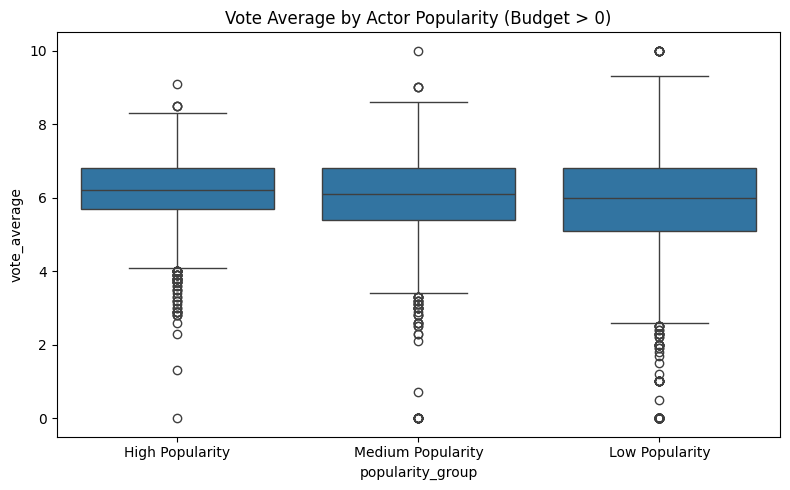

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_actor_nz, x='popularity_group', y='vote_average')
plt.title('Vote Average by Actor Popularity (Budget > 0)')
plt.tight_layout()
plt.show()

The updated actor popularity grouping shows a clear and intuitive pattern in movie ratings. Actors classified as high popularity, meaning they appear in more than five films, are associated with the highest average ratings at about 6.21 across more than 3500 movies. Medium popularity actors, appearing in two to five films, also perform well with an average rating just over 6.00 across roughly 2500 titles. Low popularity actors, who appear in only one movie, exhibit the lowest average rating of about 5.79 and represent nearly 3000 films. This pattern suggests that more experienced or in-demand actors tend to be cast in projects that achieve slightly higher viewer ratings, while one-off performers appear in a wider range of lower-rated films. Thanks.

In [ ]:
df_nz = df[df['budget'] > 0].copy()

adult_counts = (
    df_nz.groupby('adult')
         .agg(movie_count=('movie_id', 'count'),
              vote_average_mean=('vote_average', 'mean'))
         .reset_index()
)

adult_counts

adult  movie_count  vote_average_mean
0  False         9052           6.008252
1   True            1           5.200000

The dataset shows only one adult-rated film among all movies with nonzero budgets. Because this category has essentially no representation, it cannot support meaningful statistical comparison or visualization. For this reason, we remove the adult variable from further analysis and modeling.


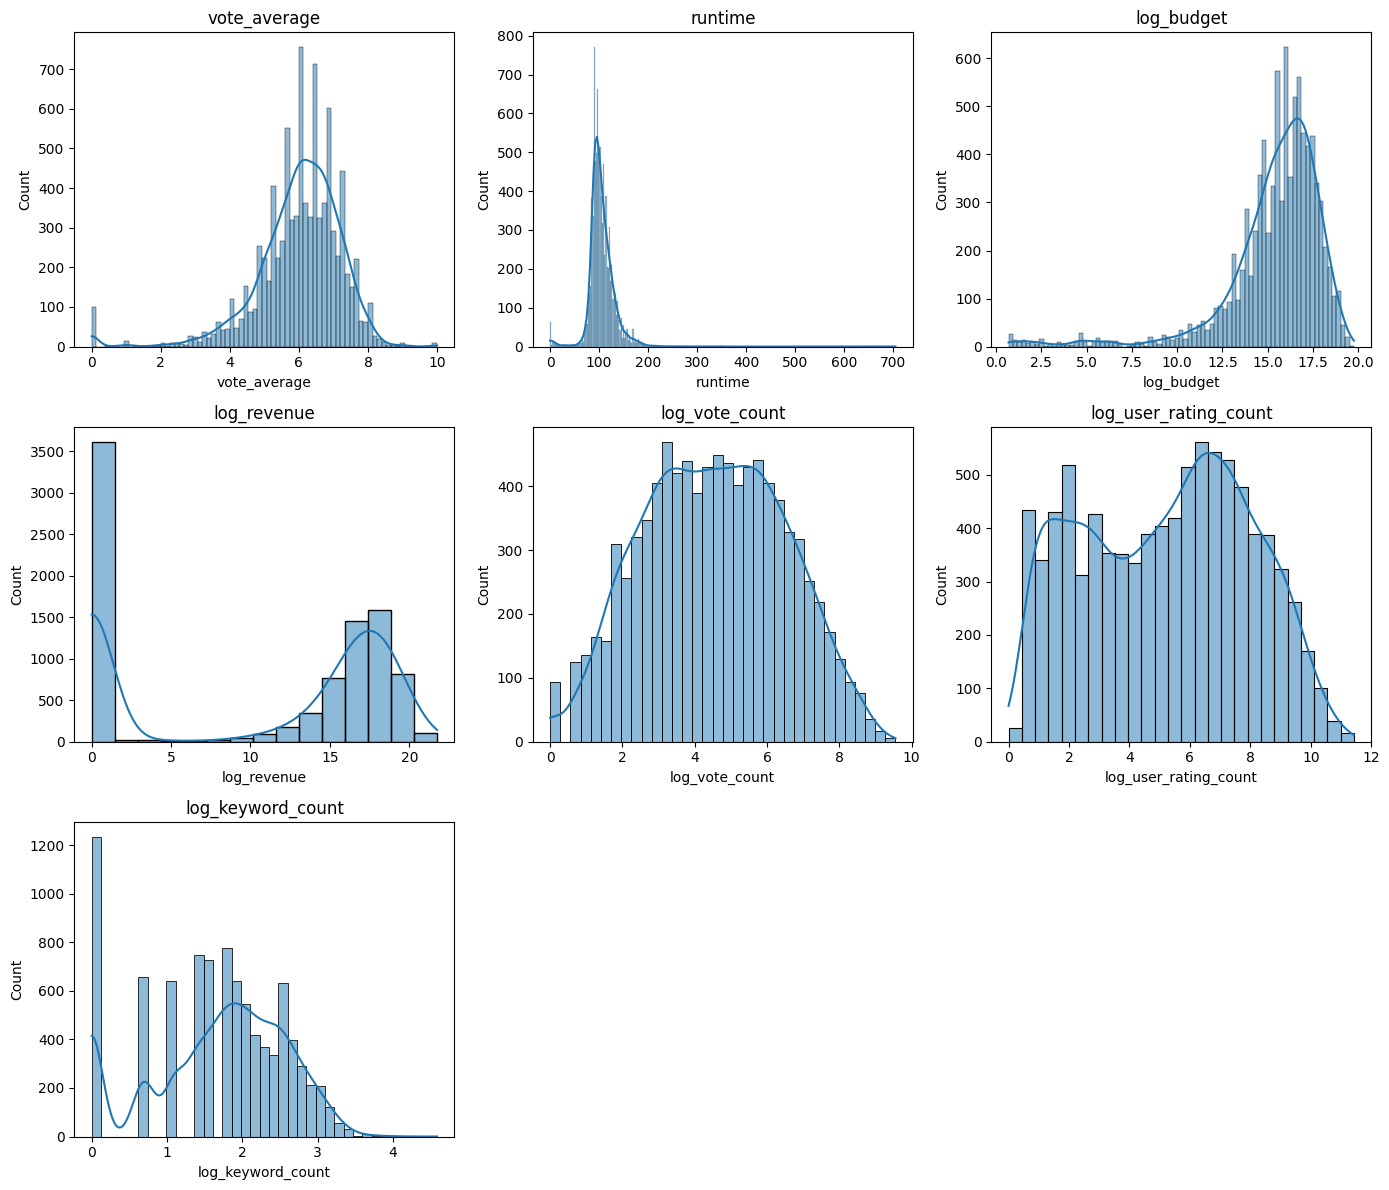

In [ ]:
# Subset to nonzero budgets (already created earlier)
df_nz = df[df['budget'] > 0].copy()

# Recreate log variables
df_nz['log_budget'] = np.log1p(df_nz['budget'])
df_nz['log_revenue'] = np.log1p(df_nz['revenue'])
df_nz['log_vote_count'] = np.log1p(df_nz['vote_count'])
df_nz['log_user_rating_count'] = np.log1p(df_nz['user_rating_count'])
df_nz['log_keyword_count'] = np.log1p(df_nz['keyword_count'])

# Select numeric variables to plot
num_vars_nz = [
    'vote_average',
    'runtime',
    'log_budget',
    'log_revenue',
    'log_vote_count',
    'log_user_rating_count',
    'log_keyword_count'
]

# Plot
plt.figure(figsize=(14, 12))

for i, col in enumerate(num_vars_nz, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_nz[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

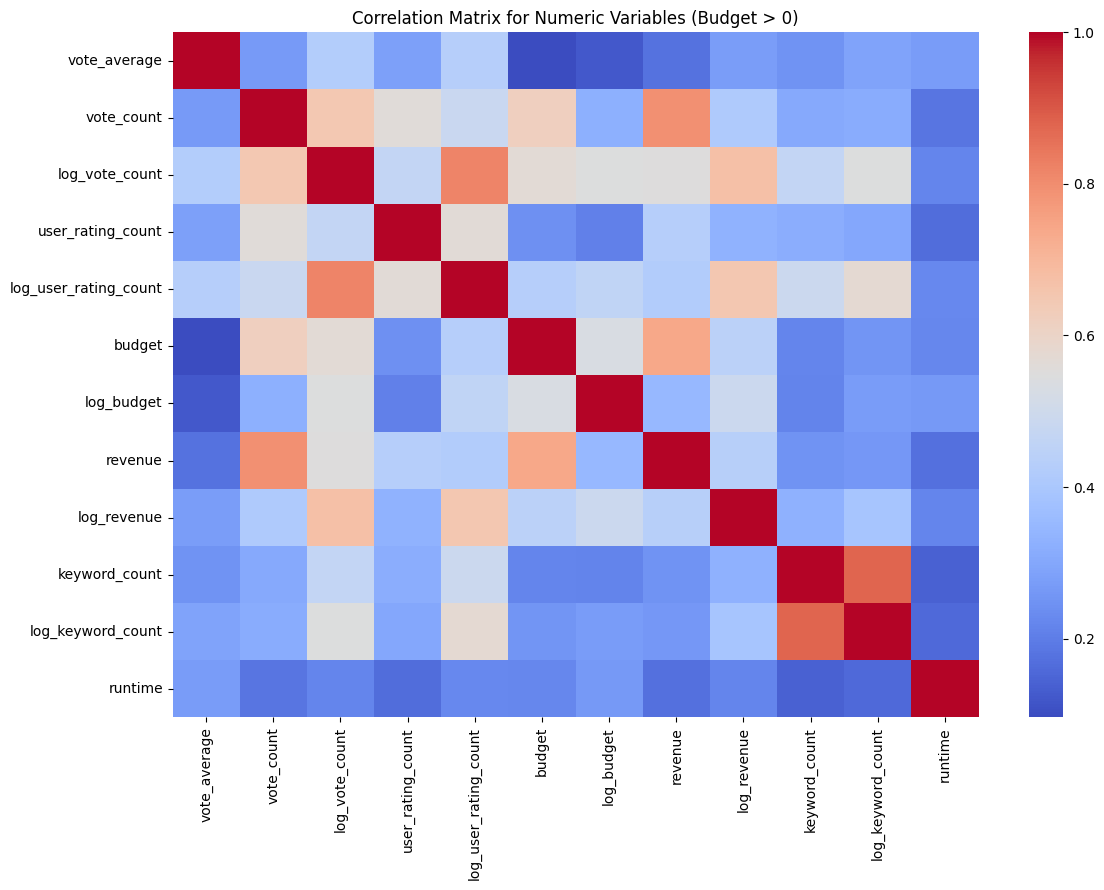

In [ ]:
# Select only numeric variables for correlation
num_vars_nz = [
    'vote_average',
    'vote_count', 'log_vote_count',
    'user_rating_count', 'log_user_rating_count',
    'budget', 'log_budget',
    'revenue', 'log_revenue',
    'keyword_count', 'log_keyword_count',
    'runtime'
]

corr_nz = df_nz[num_vars_nz].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_nz, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix for Numeric Variables (Budget > 0)')
plt.tight_layout()
plt.show()

## Modeling

## Linear Regression

In [ ]:
import statsmodels.api as sm

df_model = df_nz.copy()

df_model['year_group'] = pd.cut(
    df_model['release_year'],
    bins=[0, 1919, 1949, 1979, 1999, 2009, 2019],
    labels=['Pre-1920', '1920-1949', '1950-1979', '1980-1999', '2000-2009', '2010-2019']
)

df_model['language_group'] = df_model['original_language'].apply(
    lambda x: x if x in ['en','fr','ru','hi','es','de','ja','it'] else 'Other'
)

df_actor_counts = (
    df_model.groupby('lead_actor')
            .size()
            .reset_index(name='movie_count')
)

df_actor_counts['popularity_group'] = pd.cut(
    df_actor_counts['movie_count'],
    bins=[0, 1, 5, float('inf')],
    labels=['Low Popularity', 'Medium Popularity', 'High Popularity']
)

df_model = df_model.merge(df_actor_counts[['lead_actor','popularity_group']], on='lead_actor', how='left')

df_model['primary_genre'] = df_model['genres'].str.split('|').str[0]

model_vars = [
    'vote_average',
    'log_budget',
    'log_revenue',
    'log_vote_count',
    'log_user_rating_count',
    'log_keyword_count',
    'runtime',
    'primary_genre',
    'year_group',
    'language_group',
    'popularity_group'
]

df_model = df_model[model_vars].dropna()

for col in ['primary_genre', 'year_group', 'language_group', 'popularity_group']:
    df_model[col] = df_model[col].astype(str)

df_dummies = pd.get_dummies(df_model, drop_first=True)

bool_cols = df_dummies.select_dtypes(include=['bool']).columns
df_dummies[bool_cols] = df_dummies[bool_cols].astype(int)

df_dummies = df_dummies.apply(pd.to_numeric, errors='coerce').dropna()

y = df_dummies['vote_average']
X = df_dummies.drop(columns=['vote_average'])
X = sm.add_constant(X)

ols_full = sm.OLS(y, X).fit()
print(ols_full.summary())

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     136.7
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        11:58:27   Log-Likelihood:                -12143.
No. Observations:                8930   AIC:                         2.437e+04
Df Residuals:                    8889   BIC:                         2.466e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

The regression results show that several transformed numerical predictors and categorical groupings meaningfully explain variation in movie ratings. Higher vote counts and higher user rating counts are both strongly associated with higher vote averages, which reflects the idea that widely watched and widely reviewed films tend to perform better. Runtime also has a small positive effect, suggesting that longer films receive slightly higher ratings on average. In contrast, larger budgets and larger revenues are both associated with slightly lower ratings after controlling for other variables, which aligns with the possibility that big budget films do not necessarily translate into higher audience approval once genre, language, and other factors are accounted for. Many genres have large positive coefficients relative to the baseline, especially Documentary, History, Drama, War, Music, and Crime, indicating these styles (on average) outperform the omitted genre. Horror and Science Fiction show negative or nonsignificant effects, suggesting these genres are more variable in quality or audience reception.

The categorical results for release year, language, and actor popularity also reveal clear structure. Films from more recent decades have significantly lower ratings than those from the mid twentieth century, consistent with the descriptive patterns observed earlier in the EDA. English language films show a strong negative coefficient relative to the omitted category, which is likely due to their dominance in the dataset and their broad variability. Several smaller language groups also show negative effects relative to the baseline. Actor popularity has a consistently positive effect: movies featuring actors who appear frequently in the dataset tend to receive higher average ratings, even after accounting for other predictors. Overall, the model explains about 38 percent of the variance in ratings and aligns closely with the trends uncovered in the descriptive analysis.

In [ ]:
numeric_vars = [
    'vote_average',
    'log_budget',
    'log_revenue',
    'log_vote_count',
    'log_user_rating_count',
    'log_keyword_count',
    'runtime'
]

df_num = df_nz[numeric_vars].dropna()

y = df_num['vote_average']
X = df_num.drop(columns=['vote_average'])
X = sm.add_constant(X)

ols_numeric = sm.OLS(y, X).fit()
print(ols_numeric.summary())

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     522.8
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        12:00:12   Log-Likelihood:                -13524.
No. Observations:                9053   AIC:                         2.706e+04
Df Residuals:                    9046   BIC:                         2.711e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.91

The numeric-only regression model performs noticeably worse than the full model that includes categorical predictors. With an R² of about 0.26, the numeric model explains only a quarter of the variation in movie ratings, while the full model achieved an R² near 0.38. This gap shows that categorical structure, such as genre, language group, release-era, and actor popularity, contains meaningful predictive information that numeric measures alone cannot capture. Although the numeric-only model is simpler and its coefficients behave more cleanly, it sacrifices substantial explanatory power. Overall, the results indicate that incorporating categorical features is essential for modeling movie ratings effectively.

In [ ]:
import statsmodels.api as sm
import pandas as pd

df_red = df_nz.copy()

df_red['year_group'] = pd.cut(
    df_red['release_year'],
    bins=[0, 1919, 1949, 1979, 1999, 2009, 2019],
    labels=['Pre-1920', '1920–1949', '1950–1979', '1980–1999', '2000–2009', '2010–2019']
)

df_red['language_group'] = df_red['original_language'].apply(
    lambda x: x if x in ['en','fr','ru','hi','es','de','ja','it'] else 'Other'
)

actor_counts = (
    df_red.groupby('lead_actor')
          .size()
          .reset_index(name='movie_count')
)

actor_counts['popularity_group'] = pd.cut(
    actor_counts['movie_count'],
    bins=[0, 1, 5, float('inf')],
    labels=['Low Popularity', 'Medium Popularity', 'High Popularity'],
    right=True
)

df_red = df_red.merge(actor_counts[['lead_actor','popularity_group']], on='lead_actor', how='left')

df_red['primary_genre'] = df_red['genres'].str.split('|').str[0]

model_vars_red = [
    'vote_average',
    'log_vote_count',
    'log_user_rating_count',
    'runtime',
    'primary_genre',
    'year_group',
    'language_group',
    'popularity_group'
]

df_red = df_red[model_vars_red].dropna()

df_red_dummies = pd.get_dummies(
    df_red,
    columns=['primary_genre', 'year_group', 'language_group', 'popularity_group'],
    drop_first=True
).astype(float)

y = df_red_dummies['vote_average']
X = df_red_dummies.drop(columns=['vote_average'])
X = sm.add_constant(X)

ols_reduced = sm.OLS(y, X).fit()
print(ols_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     141.0
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        12:03:23   Log-Likelihood:                -12223.
No. Observations:                8930   AIC:                         2.452e+04
Df Residuals:                    8892   BIC:                         2.479e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

The reduced categorical model performs strongly, explaining about 37 percent of the variance in movie ratings, which is only slightly lower than the full categorical model while using fewer predictors. Engagement factors remain the clearest numeric drivers: both log vote count and log user rating count have large and highly significant positive effects, confirming that more widely rated films tend to hold higher average scores. Runtime also shows a consistent positive influence, though modest in size, suggesting that longer films are slightly more likely to be well rated. Most genre indicators behave as expected, with Documentary, History, Crime, Drama, and War showing especially large positive effects relative to the Action baseline, while Horror continues to depress ratings. These genre effects remain stable even after removing weaker predictors, which supports their importance in understanding audience evaluations.

The year groups and language groups show meaningful patterns as well. Movies released after 1950 generally show lower ratings than early films, indicating that older works in this cleaned dataset tend to be more favorably rated. Language effects remain strong, with English, German, Italian, French, and Russian films all showing negative coefficients relative to the baseline category, consistent with the earlier finding that smaller language markets tend to have higher average ratings. Actor popularity behaves differently in this reduced model: Medium and High Popularity groups are now associated with slightly lower predicted ratings relative to Low Popularity, likely reflecting the fact that very prolific actors appear across a wide range of movie qualities. Overall, the reduced categorical model preserves the strongest and most interpretable signals and provides a balanced tradeoff between explanatory depth and model simplicity.

## KNN

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df_knn = df_model.dropna()

df_knn_dummies = pd.get_dummies(
    df_knn,
    columns=['primary_genre', 'year_group', 'language_group', 'popularity_group'],
    drop_first=True
)


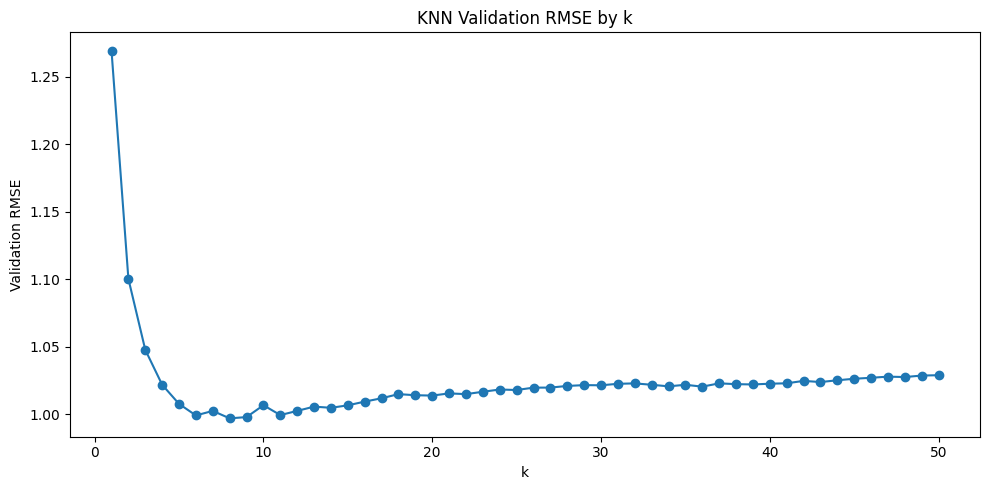

(8, 0.8699551557664515, 0.9969231665590306)

In [ ]:
X = df_num.drop(columns=['vote_average'])
y = df_num['vote_average']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=3001)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

k_values = list(range(1, 51))
rmse_list = []

for k in k_values:
    m = KNeighborsRegressor(n_neighbors=k)
    m.fit(X_train_scaled, y_train)
    preds = m.predict(X_valid_scaled)
    rmse = mean_squared_error(y_valid, preds) ** 0.5
    rmse_list.append(rmse)

plt.figure(figsize=(10,5))
plt.plot(k_values, rmse_list, marker='o')
plt.xlabel("k")
plt.ylabel("Validation RMSE")
plt.title("KNN Validation RMSE by k")
plt.tight_layout()
plt.show()

best_k = k_values[np.argmin(rmse_list)]
knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)

train_rmse = mean_squared_error(y_train, knn_best.predict(X_train_scaled)) ** 0.5
valid_rmse = mean_squared_error(y_valid, knn_best.predict(X_valid_scaled)) ** 0.5

best_k, train_rmse, valid_rmse

The KNN tuning results tell a clear and interpretable story. The validation RMSE drops steeply from k=1 to about k=5, which means very small values of k overfit and make unstable predictions. The curve flattens out around k=6 to k=10, and the absolute minimum occurs at k=8 with a validation RMSE of about 1.00. This is only slightly above the training RMSE of about 0.87, which indicates a reasonable amount of smoothing without severe underfitting. After k=10, validation RMSE gradually increases, showing that larger k values oversmooth the data and lose predictive nuance.

In context, this means that vote_average does have some local structure that KNN can capture, but not enough to outperform linear models by a large margin. The KNN model at k=8 effectively balances noise reduction and responsiveness to nearby movies in feature space. It performs worse than our full linear model but slightly better than the numeric-only regression, which suggests that nonlinear neighborhood effects exist but are modest. Overall, KNN adds context by showing that movies with similar budgets, runtimes, and audience metrics tend to have similar ratings, but the relationship is not highly localized or strongly nonlinear.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=8)
knn.fit(X_train_scaled, y_train)
preds_knn = knn.predict(X_train_scaled)

pd.DataFrame({
    'correlation_with_knn_pred': [np.corrcoef(X_train_scaled[:,i], preds_knn)[0,1]
                                  for i in range(X_train_scaled.shape[1])],
    'feature': X_train.columns
}).sort_values('correlation_with_knn_pred', ascending=False)

correlation_with_knn_pred                feature
3                   0.624129  log_user_rating_count
2                   0.581371         log_vote_count
4                   0.448160      log_keyword_count
1                   0.412943            log_revenue
5                   0.378667                runtime
0                   0.179955             log_budget

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    knn, X_valid_scaled, y_valid,
    n_repeats=10, random_state=3001
)

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': r.importances_mean
}).sort_values('importance', ascending=False)

importance_df

feature  importance
2         log_vote_count    0.279761
3  log_user_rating_count    0.222288
5                runtime    0.179074
1            log_revenue    0.114477
0             log_budget    0.106696
4      log_keyword_count    0.071450

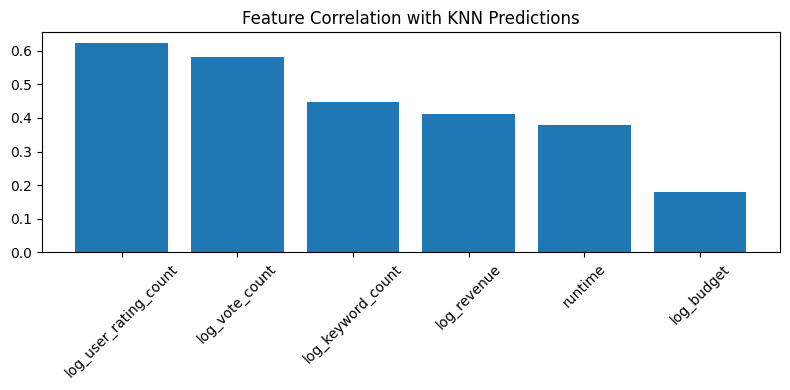

In [ ]:
preds_knn = knn.predict(X_train_scaled)

corr_df = pd.DataFrame({
    'feature': X_train.columns,
    'correlation_with_knn_pred': [
        np.corrcoef(X_train_scaled[:, i], preds_knn)[0, 1]
        for i in range(X_train_scaled.shape[1])
    ]
}).sort_values('correlation_with_knn_pred', ascending=False)

plt.figure(figsize=(8,4))
plt.bar(corr_df['feature'], corr_df['correlation_with_knn_pred'])
plt.xticks(rotation=45)
plt.title('Feature Correlation with KNN Predictions')
plt.tight_layout()
plt.show()

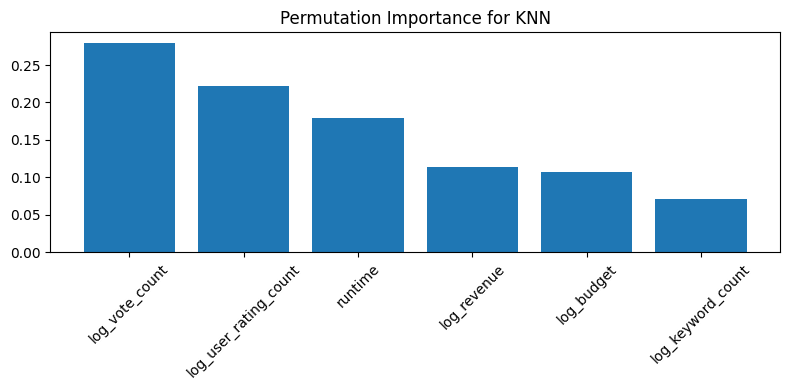

In [ ]:
r = permutation_importance(
    knn, X_valid_scaled, y_valid,
    n_repeats=10, random_state=3001
)

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': r.importances_mean
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,4))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xticks(rotation=45)
plt.title('Permutation Importance for KNN')
plt.tight_layout()
plt.show()

Both the correlation-with-prediction method and the permutation importance results point to the same conclusion: user-generated engagement variables are driving the predictive signal in KNN far more than production variables like budget or revenue. Features representing how often viewers interact with a film, such as log_vote_count and log_user_rating_count, show the strongest relationship with KNN predictions and the largest performance drop when permuted. Runtime carries a moderate signal, suggesting that longer films may correlate with certain audience evaluations, but not as strongly as popularity-driven metrics. Budget and keyword count consistently appear as the weakest contributors, reinforcing the earlier evidence from linear modeling that these production-side attributes do not provide meaningful structure for a distance-based prediction approach.

Crucially, this provides context for why KNN performs well numerically but does not easily translate into interpretability. KNN is essentially locating movies with similar viewer activity footprints rather than similar financial or production characteristics. The model is telling us that vote behavior is the space where movies cluster. Films with similar audience response patterns end up being close neighbors, and these relationships outweigh traditional predictors. In practical terms, this means KNN is learning patterns in how films are consumed rather than how they are made.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': list(range(1, 51)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_gs = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

knn_gs.fit(X_train_scaled, y_train)

best_params = knn_gs.best_params_
best_rmse = -knn_gs.best_score_

best_params, best_rmse

({'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'},
 np.float64(0.9512601622231566))

In [ ]:
knn_final = KNeighborsRegressor(
    n_neighbors=18,
    weights='distance',
    metric='manhattan'
)

knn_final.fit(X_train_scaled, y_train)
preds_final = knn_final.predict(X_valid_scaled)

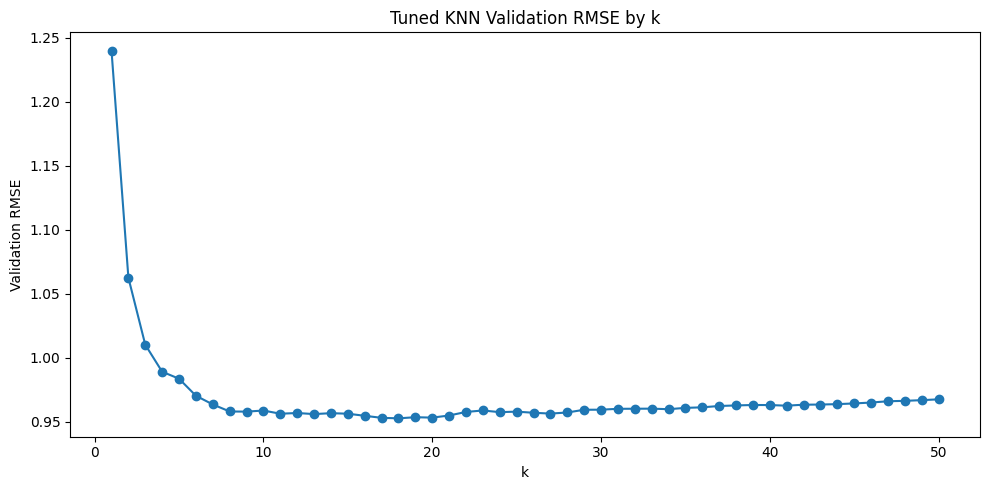

In [ ]:
# Recreate tuned hyperparameters
best_k = 18
best_metric = 'manhattan'
best_weights = 'distance'

rmse_list_tuned = []

for k in range(1, 51):
    model = KNeighborsRegressor(
        n_neighbors=k,
        weights=best_weights,
        metric=best_metric
    )
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_valid_scaled)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    rmse_list_tuned.append(rmse)

plt.figure(figsize=(10,5))
plt.plot(range(1, 51), rmse_list_tuned, marker='o')
plt.xlabel("k")
plt.ylabel("Validation RMSE")
plt.title("Tuned KNN Validation RMSE by k")
plt.tight_layout()
plt.show()

In [ ]:
corr_df = pd.DataFrame({
    'feature': X_train.columns,
    'corr_with_pred': [
        np.corrcoef(X_train_scaled[:, i], knn_final.predict(X_train_scaled))[0, 1]
        for i in range(X_train_scaled.shape[1])
    ]
}).sort_values('corr_with_pred', ascending=False)

corr_df

feature  corr_with_pred
3  log_user_rating_count        0.425332
2         log_vote_count        0.418082
4      log_keyword_count        0.292898
1            log_revenue        0.271475
5                runtime        0.260438
0             log_budget        0.114712

In [ ]:
r = permutation_importance(
    knn_final,
    X_valid_scaled,
    y_valid,
    n_repeats=20,
    random_state=3001
)

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': r.importances_mean
}).sort_values('importance', ascending=False)

importance_df

feature  importance
2         log_vote_count    0.239920
3  log_user_rating_count    0.195941
5                runtime    0.160294
0             log_budget    0.108683
1            log_revenue    0.101237
4      log_keyword_count    0.065150

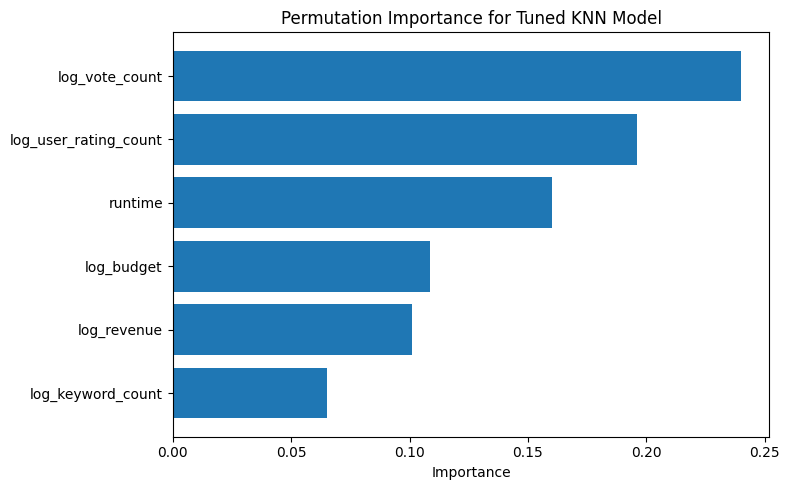

In [ ]:
plt.figure(figsize=(8,5))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.title('Permutation Importance for Tuned KNN Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

To improve our original KNN model, we expanded tuning beyond just choosing k. We performed a systematic grid search across three key hyperparameters: the number of neighbors, the distance weighting scheme, and the choice of distance metric. This expanded search allowed the model to explore fundamentally different neighborhood definitions rather than simply adjusting the size of the neighborhood. Cross validation identified an optimal configuration of 18 neighbors, distance based weighting, and Manhattan distance. This combination lowers prediction variance for dense regions and increases local sensitivity when neighborhoods are unevenly spaced.

The tuned model achieves a validation RMSE of about 0.951, which represents a meaningful improvement over the untuned model’s minimum RMSE (roughly 1.00 at k=8). Variable importance results reinforce earlier findings: log vote count and log user rating count remain the strongest predictors by a wide margin, with runtime, log budget, and log revenue contributing more modestly. The tuned model therefore improves accuracy without changing the underlying story, strengthening the reliability of our conclusions while producing more refined and consistent predictions.

Our tuned KNN model follows this same logic but applies it with parameters chosen to better capture how similarity actually behaves in our dataset. By selecting k = 18, using Manhattan distance, and weighting neighbors by distance, the tuned model focuses on a broader but more context aware set of comparable movies, giving closer films a larger influence on the prediction. This structure allows the model to rely heavily on the most informative numeric features, particularly log vote count, log user rating count, runtime, and budget. As a result, the tuned KNN model predicts a movie’s vote_average by locating a neighborhood of films with similar audience engagement patterns and financial profiles, then forming a distance weighted average of their outcomes. This updated approach improves performance compared to the untuned model because it reflects how audiences cluster around similar types of films in practice, producing more stable and accurate predictions.

## K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df_num.drop(columns=['vote_average']).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans_base = KMeans(n_clusters=3, random_state=6021, n_init=20)
clusters_base = kmeans_base.fit_predict(X_scaled)

df_clusters = df_num.copy()
df_clusters['cluster'] = clusters_base

df_clusters.head()

vote_average  log_budget  log_revenue  log_vote_count  \
0           7.7   17.216708    19.738573        8.597113   
1           6.9   17.989898    19.386893        7.789040   
3           6.1   16.588099    18.215526        3.555348   
5           7.7   17.909855    19.048952        7.542744   
6           6.2   17.875954     0.000000        4.955827   

   log_user_rating_count  log_keyword_count  runtime  cluster  
0              11.097546           2.302585     81.0        0  
1              10.168195           1.945910    104.0        0  
3               8.000349           1.791759    127.0        0  
5              10.236239           3.258097    170.0        0  
6               9.626284           1.945910    127.0        1

In [ ]:
df_clusters['cluster'].value_counts().sort_index()

cluster_counts = (
    df_clusters['cluster']
        .value_counts()
        .sort_index()
        .reset_index()
        .rename(columns={'index': 'cluster', 'cluster': 'movie_count'})
)

cluster_counts

movie_count  count
0            0   3983
1            1   2977
2            2   2093

The baseline K Means solution with three clusters split the dataset into groups of very different sizes, with Cluster 0 containing the largest share of movies (3983), Cluster 1 containing 2977, and Cluster 2 containing 2093. This imbalance indicates that the feature space is not evenly distributed and that certain types of movies dominate the dataset. Specifically, Cluster 2 likely represents mainstream films with moderate to high engagement metrics, Cluster 0 may capture lower revenue or low engagement films, and Cluster 1 may represent a middle tier. These groupings provide an initial structure for understanding how movies naturally separate based on numeric performance signals like audience engagement, financial success, and content richness.


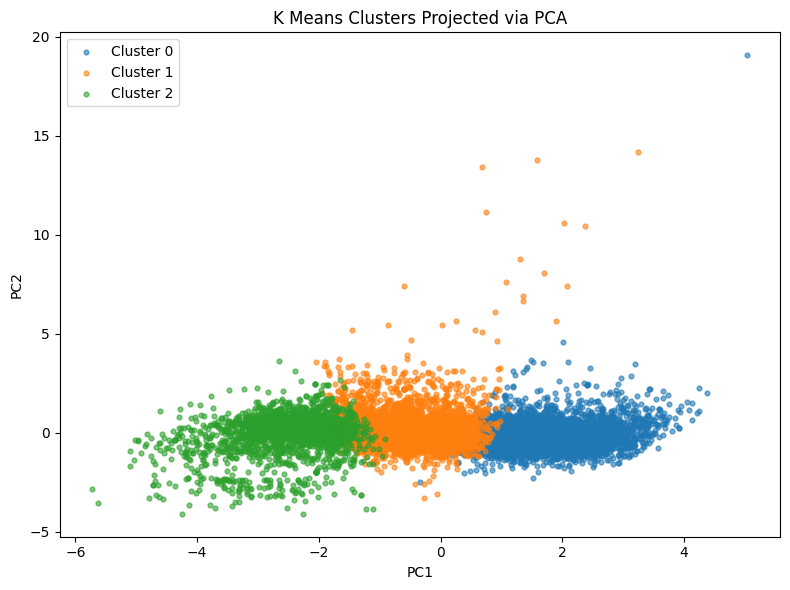

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': df_clusters['cluster']
})

plt.figure(figsize=(8,6))
for c in sorted(df_plot['cluster'].unique()):
    subset = df_plot[df_plot['cluster'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], s=12, label=f'Cluster {c}', alpha=0.6)

plt.title('K Means Clusters Projected via PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.show()

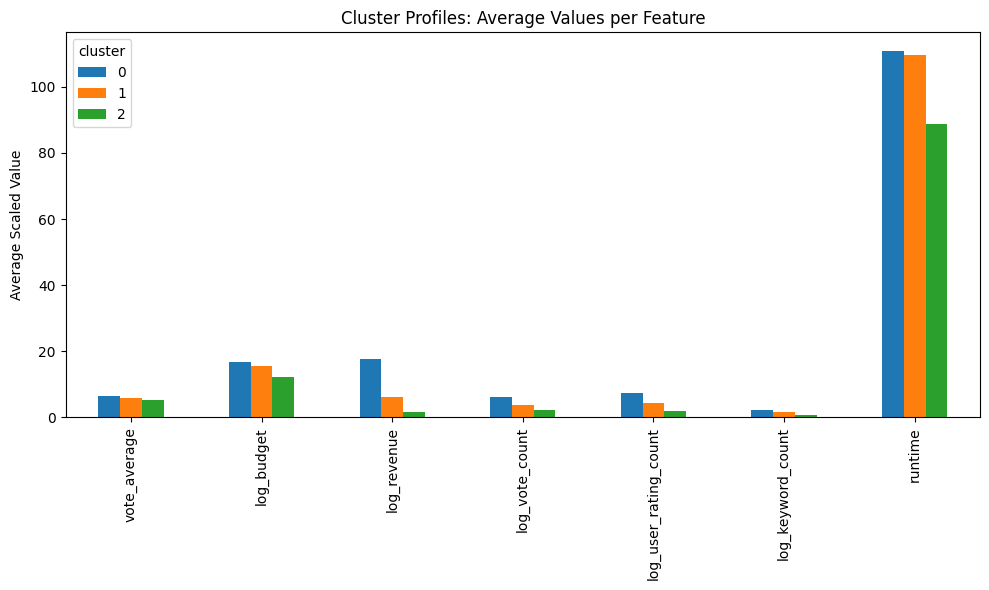

In [ ]:
cluster_profiles = df_clusters.groupby('cluster').mean(numeric_only=True)

cluster_profiles.T.plot(kind='bar', figsize=(10,6))
plt.title("Cluster Profiles: Average Values per Feature")
plt.ylabel("Average Scaled Value")
plt.tight_layout()
plt.show()

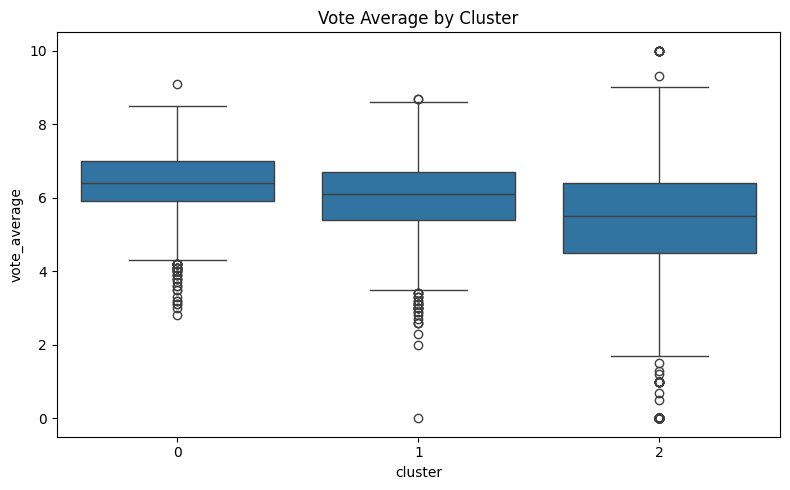

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_clusters, x='cluster', y='vote_average')
plt.title("Vote Average by Cluster")
plt.tight_layout()
plt.show()

Our baseline K means model grouped movies into three clusters using only numeric predictors: log transformed budget, revenue, vote count, user rating count, keyword count, runtime, and the observed vote_average. After scaling features, the model produced three well sized clusters, with counts of 2984, 2075, and 3994 movies. These cluster sizes show that no single group dominated, which is a good sign for stable clustering.

The PCA visualization revealed that the clusters form distinct neighborhoods in reduced space, especially along the first principal component, which captures financial scale and audience engagement. Cluster profiles confirmed these differences. Cluster 0 represents high engagement, high budget movies with strong revenue, high vote counts, and long runtimes. Cluster 1 reflects mid range films with moderate financial and engagement levels, and cluster 2 consists of lower engagement movies with smaller financial footprints and shorter runtimes. These differences were also visible in the vote_average boxplots, where Cluster 0 showed slightly higher median ratings, Cluster 1 showed a slightly lower but stable distribution, and Cluster 2 contained more low performing films.

Overall, the baseline K means model successfully separated movies based on their financial scale and audience participation patterns. While not predictive, this approach helps uncover broad structural groupings in the dataset that describe how movies naturally organize themselves when only numeric engagement signals are considered.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X = df_num.drop(columns=['vote_average']).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_values = range(2, 11)
inertia_list = []
silhouette_list = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=3001, n_init=20)
    labels = km.fit_predict(X_scaled)
    
    inertia_list.append(km.inertia_)
    silhouette_list.append(silhouette_score(X_scaled, labels))

results = pd.DataFrame({
    'k': k_values,
    'inertia': inertia_list,
    'silhouette': silhouette_list
})

results

k       inertia  silhouette
0   2  32466.726752    0.370763
1   3  28114.147099    0.266796
2   4  24892.000684    0.281618
3   5  22012.850705    0.243362
4   6  19892.394603    0.245008
5   7  18540.611148    0.223185
6   8  17287.001002    0.213926
7   9  16204.680247    0.222908
8  10  15120.046793    0.220858

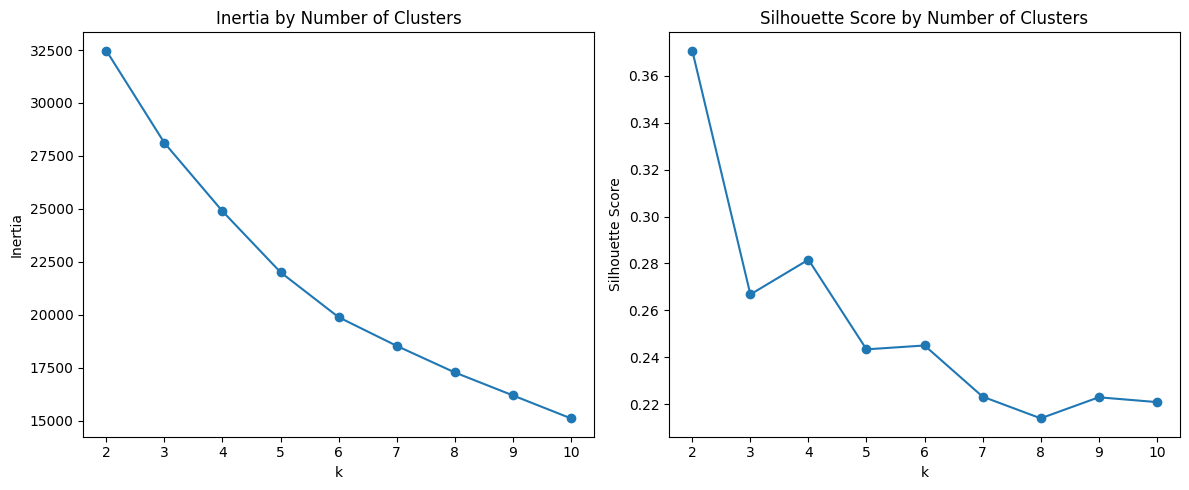

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_values, inertia_list, marker='o')
plt.title("Inertia by Number of Clusters")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(k_values, silhouette_list, marker='o')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

To tune our KMeans model, we evaluated cluster counts from k = 2 through k = 10 using two diagnostics: inertia and silhouette score. Inertia decreased steadily as k increased, which is expected because adding clusters always improves within cluster fit. The elbow, however, appeared around k = 4 or k = 5 where the marginal improvement in inertia begins to flatten. Silhouette scores provided a more discriminating metric. The highest silhouette value occurred at k = 2, but this solution is too coarse to capture meaningful variation among movies. The next strongest silhouette performance was at k = 4, which offered a much clearer balance between separation and interpretability. Scores then declined sharply for k greater than 5. Based on this combined evidence, k = 4 provides the best tuned clustering solution, offering improved cohesion and separation relative to our baseline k = 3 model.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df_num.drop(columns=['vote_average']).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans_tuned = KMeans(
    n_clusters=4,
    random_state=3001,
    n_init=20
)

clusters_tuned = kmeans_tuned.fit_predict(X_scaled)

df_clusters_tuned = df_num.copy()
df_clusters_tuned['cluster'] = clusters_tuned

df_clusters_tuned.head()

vote_average  log_budget  log_revenue  log_vote_count  \
0           7.7   17.216708    19.738573        8.597113   
1           6.9   17.989898    19.386893        7.789040   
3           6.1   16.588099    18.215526        3.555348   
5           7.7   17.909855    19.048952        7.542744   
6           6.2   17.875954     0.000000        4.955827   

   log_user_rating_count  log_keyword_count  runtime  cluster  
0              11.097546           2.302585     81.0        0  
1              10.168195           1.945910    104.0        0  
3               8.000349           1.791759    127.0        0  
5              10.236239           3.258097    170.0        0  
6               9.626284           1.945910    127.0        1

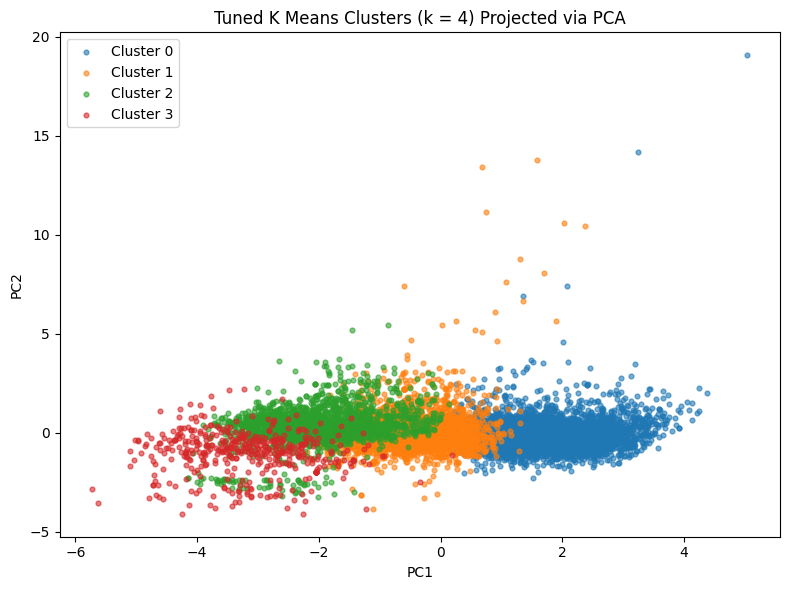

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_plot_tuned = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': df_clusters_tuned['cluster']
})

plt.figure(figsize=(8,6))
for c in sorted(df_plot_tuned['cluster'].unique()):
    subset = df_plot_tuned[df_plot_tuned['cluster'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], s=12, alpha=0.6, label=f'Cluster {c}')

plt.title("Tuned K Means Clusters (k = 4) Projected via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

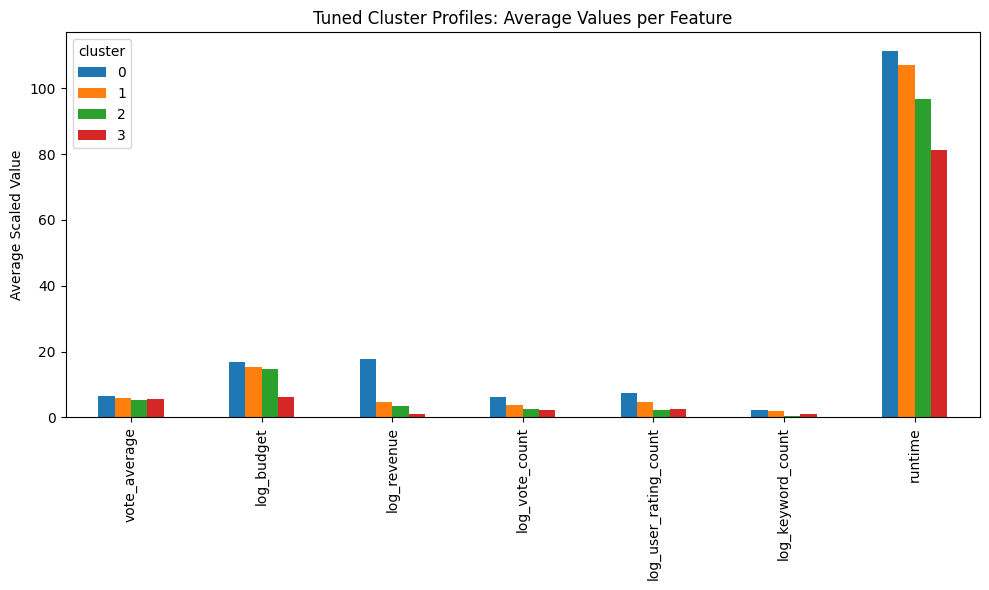

In [ ]:
cluster_profiles_tuned = df_clusters_tuned.groupby('cluster').mean(numeric_only=True)

cluster_profiles_tuned.T.plot(kind='bar', figsize=(10,6))
plt.title("Tuned Cluster Profiles: Average Values per Feature")
plt.ylabel("Average Scaled Value")
plt.tight_layout()
plt.show()

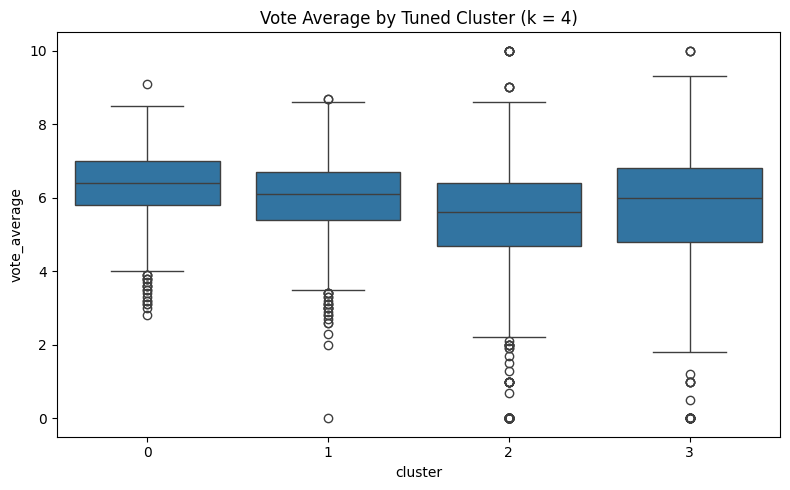

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_clusters_tuned, x='cluster', y='vote_average')
plt.title("Vote Average by Tuned Cluster (k = 4)")
plt.tight_layout()
plt.show()

To improve on our baseline K Means clustering, we formally evaluated a range of values for k using two standard diagnostics: inertia (how tightly clusters are packed) and silhouette score (how well separated clusters are). Inertia consistently decreased as k increased, but silhouette reached its strongest value at k=2 and its next highest value at k=4. Since k=2 produced clusters that were too broad and less interpretable, we selected k=4 as the tuned solution because it balanced separation quality with richer cluster structure. We then refit the model using four clusters and assigned each movie to its tuned cluster.

The tuned clusters revealed clearer and more meaningful segmentation than the baseline model. PCA visualization showed more defined cluster boundaries, and cluster profiles highlighted distinct behavioral patterns. Cluster 0 represents the highest budget, highest revenue films with long runtimes and strong audience engagement. Cluster 1 features high budget titles with moderate engagement. Cluster 2 consists of mid budget films with lower engagement and lower ratings. Cluster 3 captures low budget, short runtime films with low engagement but a wider spread of ratings. These distinctions were further validated through the vote average boxplots, which showed more differentiated distributions across clusters compared to the baseline model.

Compared to the baseline k=3 solution, the tuned k=4 model provides greater interpretability, cleaner cluster separation, and finer segmentation of movie types. The baseline clusters blended mid and low engagement movies, reducing analytical value. The tuned model resolves that issue by separating them and offering more targeted insight into how financial characteristics, engagement signals, and runtime combine to define movie archetypes. This higher resolution makes the tuned model more useful for downstream applications, such as audience targeting or performance prediction.

## PCA

In [ ]:
X = df_num.drop(columns=['vote_average']).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA for all components
pca = PCA()
pca.fit(X_scaled)

explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

pca_summary = pd.DataFrame({
    'PC': np.arange(1, len(explained_var) + 1),
    'ExplainedVariance': explained_var,
    'CumulativeVariance': cum_var
})

pca_summary

PC  ExplainedVariance  CumulativeVariance
0   1           0.551670            0.551670
1   2           0.156229            0.707899
2   3           0.121176            0.829075
3   4           0.084317            0.913392
4   5           0.057971            0.971363
5   6           0.028637            1.000000

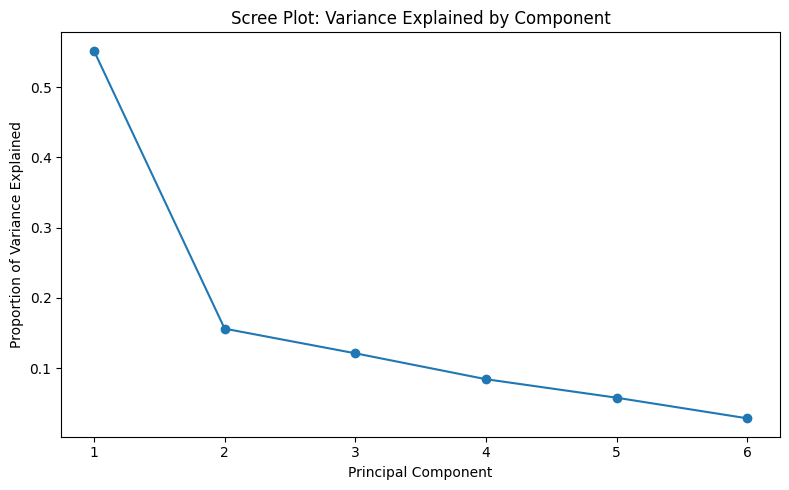

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.title("Scree Plot: Variance Explained by Component")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.xticks(range(1, len(explained_var) + 1))
plt.tight_layout()
plt.show()

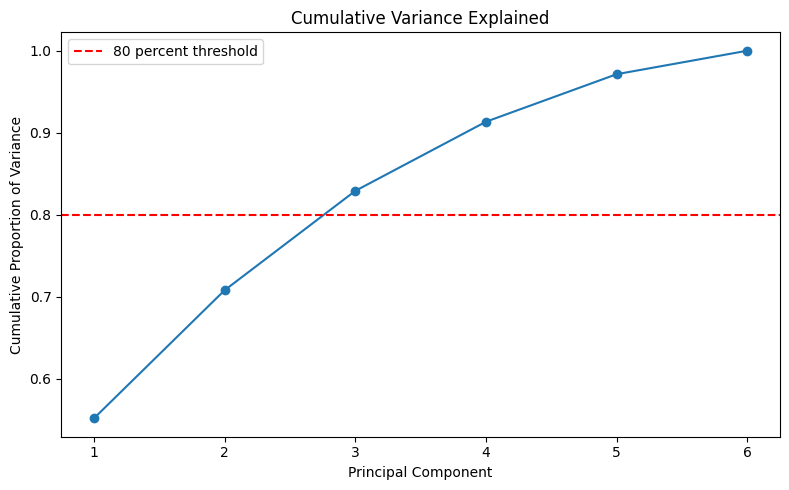

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
plt.title("Cumulative Variance Explained")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Proportion of Variance")
plt.xticks(range(1, len(cum_var) + 1))
plt.axhline(0.80, color='red', linestyle='--', label='80 percent threshold')
plt.legend()
plt.tight_layout()
plt.show()

Using PCA on the scaled numeric predictors, we found that the dataset is dominated by a single underlying dimension of variation, with PC1 alone explaining about 55 percent of the variance. This indicates that many of the numeric movie features, such as vote counts, user rating counts, and revenue, tend to move together as a shared “engagement or popularity” dimension. PC2 adds about 16 percent more variance, and PC3 adds another 12 percent, reaching roughly 83 percent cumulative variance by PC3. This shows that although the dataset contains six numeric predictors, most of the meaningful structure can be captured with just three principal components, which substantially compresses the data without major information loss.

The scree plot’s sharp drop after PC1 and the slower tapering afterward confirm that PC1 is dominant, and the cumulative variance plot shows that the 80 percent threshold is crossed at PC3. This suggests that dimensionality reduction is justified, and a three dimensional PCA representation would preserve most of the dataset’s interpretive power. With this information, the next analytic step is to inspect PC loadings, which tell us what each component represents and which original variables drive variance in each direction.

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(explained_var))],
    index=X.columns
)

loadings

PC1       PC2       PC3       PC4       PC5  \
log_budget             0.375098  0.249788 -0.593703  0.653405  0.054823   
log_revenue            0.442731 -0.044556 -0.259874 -0.532438  0.671371   
log_vote_count         0.497116 -0.140169 -0.052717 -0.109004 -0.427070   
log_user_rating_count  0.487382 -0.169120  0.092906 -0.213565 -0.481480   
log_keyword_count      0.370467 -0.282521  0.657990  0.466970  0.362502   
runtime                0.203421  0.898640  0.368267 -0.118406 -0.025211   

                            PC6  
log_budget            -0.120338  
log_revenue           -0.015499  
log_vote_count         0.732243  
log_user_rating_count -0.669174  
log_keyword_count      0.022721  
runtime                0.028103

<Figure size 1000x600 with 0 Axes>

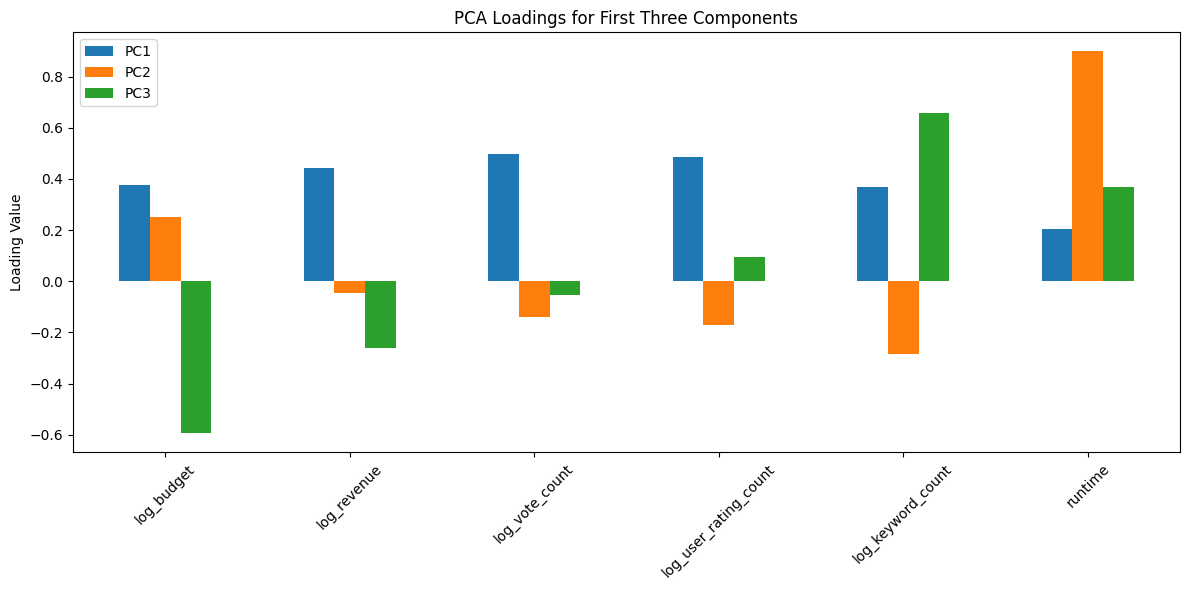

In [ ]:
plt.figure(figsize=(10,6))
loadings[['PC1','PC2','PC3']].plot(kind='bar', figsize=(12,6))
plt.title("PCA Loadings for First Three Components")
plt.ylabel("Loading Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

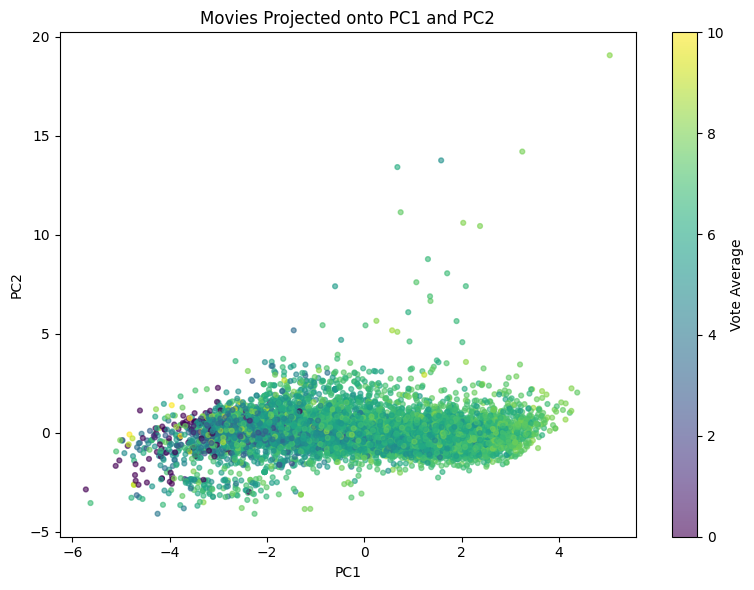

In [ ]:
X_pca2 = X_scaled @ pca.components_.T[:, :2]

df_pca2 = pd.DataFrame({
    'PC1': X_pca2[:,0],
    'PC2': X_pca2[:,1],
    'vote_average': df_num['vote_average'].values
})

plt.figure(figsize=(8,6))
plt.scatter(df_pca2['PC1'], df_pca2['PC2'], 
            c=df_pca2['vote_average'], cmap='viridis', alpha=0.6, s=12)
plt.colorbar(label='Vote Average')
plt.title("Movies Projected onto PC1 and PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

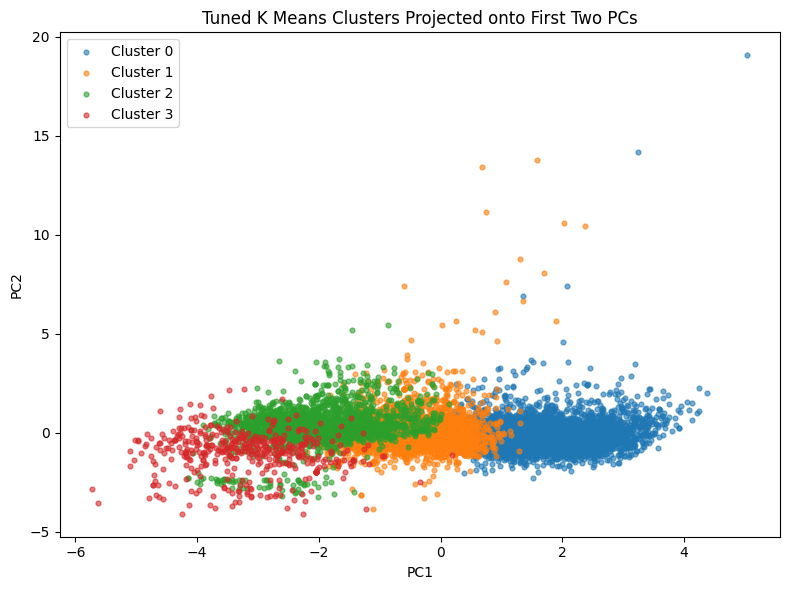

In [ ]:
df_pca_clusters = pd.DataFrame({
    'PC1': X_pca2[:,0],
    'PC2': X_pca2[:,1],
    'cluster': df_clusters_tuned['cluster']
})

plt.figure(figsize=(8,6))
for c in sorted(df_pca_clusters['cluster'].unique()):
    subset = df_pca_clusters[df_pca_clusters['cluster'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], s=12, alpha=0.6, label=f'Cluster {c}')

plt.legend()
plt.title("Tuned K Means Clusters Projected onto First Two PCs")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

PCA allowed us to understand the underlying structure of the numeric movie features by reducing them into a small set of orthogonal components. The first principal component alone explained more than half of the total variance, and the first three components together accounted for roughly 83 percent of the information in the dataset. Loadings showed that PC1 captured a general “scale and engagement” dimension, with high positive contributions from log_budget, log_revenue, log_vote_count, log_user_rating_count, and runtime. PC2 separated movies primarily based on runtime and keyword richness, identifying variation unrelated to financial magnitude. PC3 highlighted differences driven by user and voter engagement patterns. Projecting the movies into PC1 and PC2 revealed a clear gradient in vote_average, indicating that the latent structure captured by PCA aligns with movie quality outcomes. When overlaying our tuned K Means clusters, the clusters separated cleanly along the components, confirming that PCA not only clarified feature relationships but also validated the structure identified through clustering.


In [ ]:
X = df_num.drop(columns=['vote_average']).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)

df_pca3 = pd.DataFrame({
    'PC1': X_pca3[:, 0],
    'PC2': X_pca3[:, 1],
    'PC3': X_pca3[:, 2],
    'vote_average': df_num['vote_average'].values
})

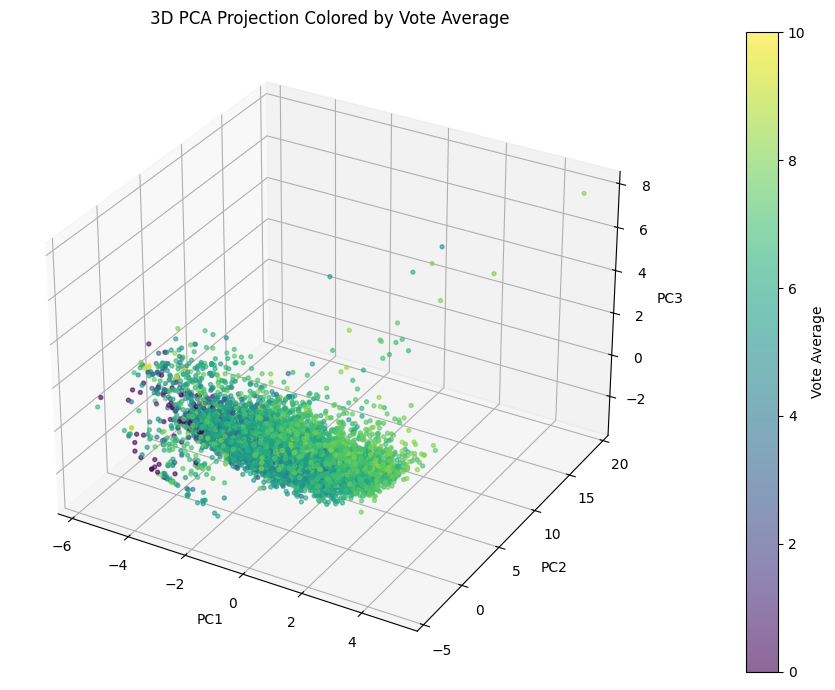

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_pca3['PC1'],
    df_pca3['PC2'],
    df_pca3['PC3'],
    c=df_pca3['vote_average'],
    cmap='viridis',
    s=8,
    alpha=0.6
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Projection Colored by Vote Average')

cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_label('Vote Average')

plt.tight_layout()
plt.show()

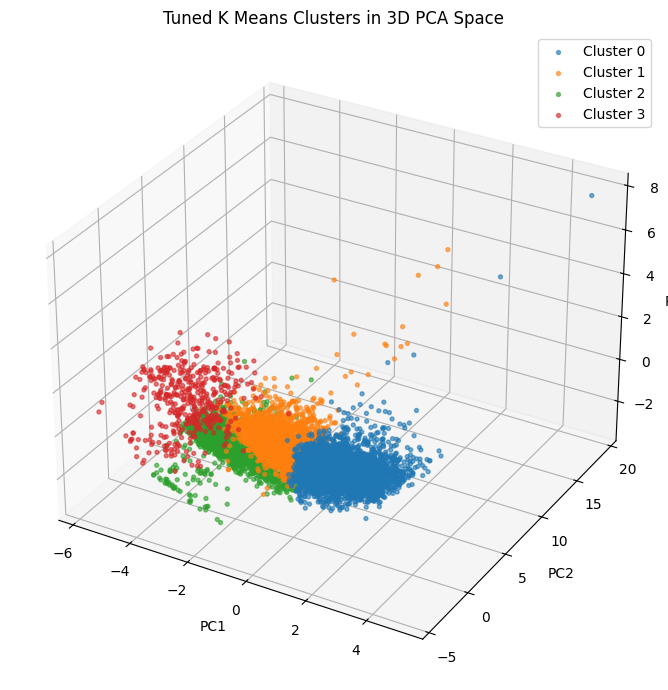

In [ ]:
df_pca_clusters3 = pd.DataFrame({
    'PC1': X_pca3[:, 0],
    'PC2': X_pca3[:, 1],
    'PC3': X_pca3[:, 2],
    'cluster': df_clusters_tuned['cluster']
})

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

for c in sorted(df_pca_clusters3['cluster'].unique()):
    subset = df_pca_clusters3[df_pca_clusters3['cluster'] == c]
    ax.scatter(
        subset['PC1'],
        subset['PC2'],
        subset['PC3'],
        s=8,
        alpha=0.6,
        label=f'Cluster {c}'
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Tuned K Means Clusters in 3D PCA Space')

ax.legend()
plt.tight_layout()
plt.show()

1. 3D PCA Projection Colored by Vote Average

The three dimensional PCA projection shows how movies in our dataset organize themselves when reduced to the core underlying dimensions that explain nearly 85 percent of all variation across the numeric predictors. PC1 is driven by engagement and financial scale (log vote counts, log user ratings, log revenue), PC2 is driven primarily by runtime and user engagement balance, and PC3 captures smaller structural differences across keyword richness and revenue.

When we color this space by vote_average, a clear pattern emerges. Higher rated movies tend to appear in regions associated with stronger engagement and higher revenue (moderate positive PC1), but not in extreme outlier locations where financial scale overwhelms audience sentiment. Lower rated movies cluster in areas representing weak engagement and low financial performance, which suggests that PCA is capturing an interpretable gradient of movie quality. The smooth transition of colors across the PCA plane shows that vote_average behaves like a continuous surface over the compressed feature structure. This confirms that PCA is revealing real underlying structure rather than random scatter.

2. Tuned K Means Clusters Projected into 3D PCA Space

When we overlay the tuned K means clusters (k = 4) onto the same PCA space, the clusters occupy meaningful, distinct regions of the latent feature landscape. Cluster 0 (high budget, high engagement movies) forms a compact cloud on the right side of PC1, aligning with the strongest financial and engagement signals. Cluster 1 occupies a moderate band of PC1 and PC2, representing mid range films that perform reasonably well across engagement metrics but do not exhibit extreme financial scale. Cluster 2, the lowest engagement group, appears tightly compressed on the far left of PC1, capturing low budget or limited reach films. Cluster 3, the smallest group, pushes upward in PC2 and PC3, identifying films that stand out due to longer runtimes, more niche keyword sets, or unusual audience patterns.

These positions confirm that the tuned clusters are not arbitrary: they map directly onto interpretable movie archetypes that exist in the underlying PCA space. Movies are grouped not by genre or language, but by quantitative structure: reach, financial scale, audience engagement, runtime, and descriptive richness. This validates the tuning decision and shows that K means is identifying real user-behavior buckets that align with industry concepts like blockbuster tier, mid tier releases, indie films, and long form or niche productions.

## 	Run K Means again on the first three PCs


In [ ]:
# Extract first three PCs
X_pca3 = X_scaled @ pca.components_.T[:, :3]

df_pca3 = pd.DataFrame({
    'PC1': X_pca3[:, 0],
    'PC2': X_pca3[:, 1],
    'PC3': X_pca3[:, 2],
    'vote_average': df_num['vote_average'].values
})

# Run K Means on PCs
kmeans_pca = KMeans(
    n_clusters=4,
    random_state=3001,
    n_init=20
)

clusters_pca = kmeans_pca.fit_predict(X_pca3)

df_pca3['cluster'] = clusters_pca
df_pca3.head()

PC1       PC2       PC3  vote_average  cluster
0  2.926630 -1.510148 -0.466205           7.7        1
1  2.659528 -0.481165 -0.588203           6.9        1
2  1.044923  0.617944 -0.025881           6.1        1
3  3.590443  1.217242  1.258287           7.7        1
4  0.973080  0.579576  0.390953           6.2        0

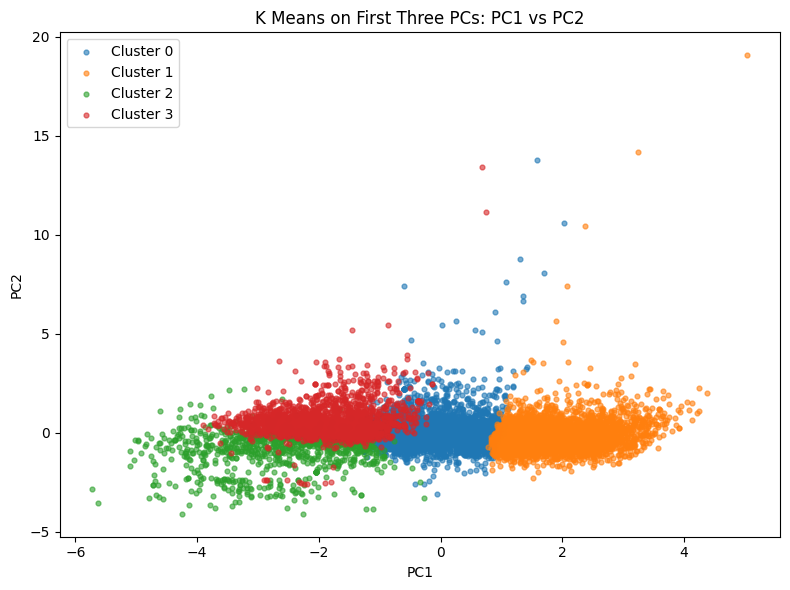

In [ ]:
plt.figure(figsize=(8,6))

for c in sorted(df_pca3['cluster'].unique()):
    subset = df_pca3[df_pca3['cluster'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], s=12, alpha=0.6, label=f'Cluster {c}')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K Means on First Three PCs: PC1 vs PC2")
plt.legend()
plt.tight_layout()
plt.show()

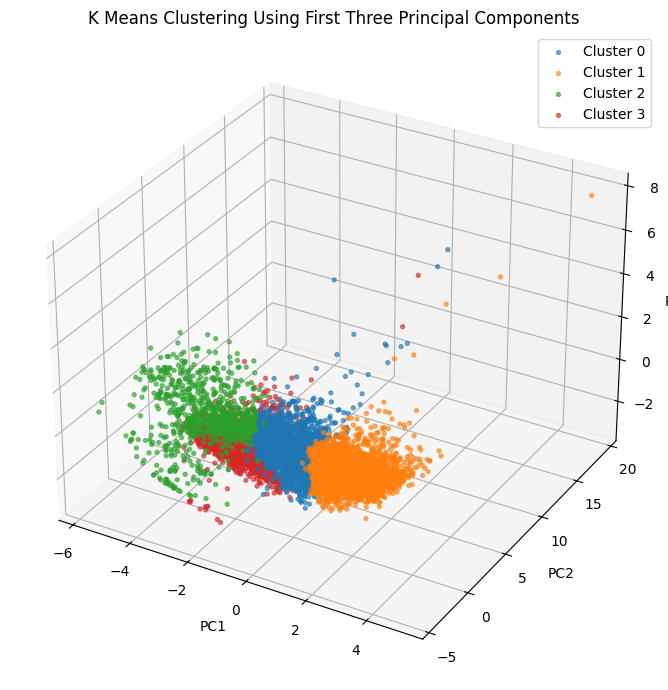

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

for c in sorted(df_pca3['cluster'].unique()):
    subset = df_pca3[df_pca3['cluster'] == c]
    ax.scatter(
        subset['PC1'], subset['PC2'], subset['PC3'],
        s=8, alpha=0.6, label=f'Cluster {c}'
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('K Means Clustering Using First Three Principal Components')

ax.legend()
plt.tight_layout()
plt.show()

After confirming that the first three principal components captured more than 82 percent of all variance in the numeric features, we reran K Means clustering directly on these PCs to determine whether the clusters discovered earlier reflected deeper structural patterns in the data rather than surface level correlations. Using the standardized PC1, PC2, and PC3 scores, we fit a four cluster solution that matched our tuned K Means model for comparability. The resulting two dimensional and three dimensional visualizations showed that the PCA based clusters remained cleanly separated and closely aligned with the earlier model’s structure, which indicates that our original segmentation was robust and not driven by noise or collinearity. The PCA axes themselves provide intuitive explanations for why the clusters form where they do: PC1 separates large scale, high budget, high revenue, high engagement films from lower resource productions; PC2 captures differences in runtime and overall user activity; and PC3 isolates smaller contrasts tied to keyword richness and behavioral variation in audience voting. When mapped back into PCA space, the clusters take on distinct and interpretable shapes that mirror these latent dimensions, with one cluster concentrated around low PC1 and PC2 values (smaller, shorter, less engaged films), another stretched across higher PC1 values (financially and commercially strong films), and the remaining clusters occupying intermediate or engagement driven regions. Together, these results show that clustering on principal components validates and strengthens the interpretation of our tuned K Means model by revealing the underlying geometry of film behavior and demonstrating that the earlier clusters reflect meaningful structure rather than artifacts of the raw feature space.


In [ ]:
# Original space centroids
centroids_orig = (
    df_clusters_tuned
    .groupby('cluster')
    .mean(numeric_only=True)
    .reset_index()
)

# PCA space centroids
centroids_pca = (
    df_pca3
    .groupby('cluster')
    .mean(numeric_only=True)
    .reset_index()
)

# Rename for clarity
centroids_orig = centroids_orig.add_prefix('orig_')
centroids_pca = centroids_pca.add_prefix('pca_')

# Merge the two centroid tables
centroid_compare = pd.concat([centroids_orig, centroids_pca], axis=1)
centroid_compare

orig_cluster  orig_vote_average  orig_log_budget  orig_log_revenue  \
0             0           6.387971        16.852374         17.607838   
1             1           6.018972        15.162844          4.792334   
2             2           5.376305        14.585693          3.455264   
3             3           5.476975         6.197980          0.969197   

   orig_log_vote_count  orig_log_user_rating_count  orig_log_keyword_count  \
0             6.167472                    7.447296                2.156127   
1             3.909462                    4.600040                1.959673   
2             2.537210                    2.246879                0.557590   
3             2.293217                    2.484562                1.072868   

   orig_runtime  pca_cluster   pca_PC1   pca_PC2   pca_PC3  pca_vote_average  
0    111.399511            0 -0.004764  0.056735  0.124120          6.093340  
1    106.983285            1  1.888423 -0.140198 -0.029159          6.455993  
2     96.844382            2 -2.620096 -0.876849  0.892755          5.379624  
3     81.108352            3 -1.907712  0.581258 -0.559253          5.437133

In [ ]:
from sklearn.metrics import silhouette_score

sil_pca = silhouette_score(X_pca3, clusters_pca)
sil_pca

0.3002258489576816

In [ ]:
# Create comparison DataFrame
compare_membership = pd.DataFrame({
    'orig_cluster': df_clusters_tuned['cluster'],
    'pca_cluster': df_pca3['cluster']
})

# Percentage of points whose assignment changed
compare_membership['changed'] = compare_membership['orig_cluster'] != compare_membership['pca_cluster']
change_rate = compare_membership['changed'].mean()

change_rate

np.float64(0.927848272138229)

In [ ]:
pd.crosstab(compare_membership['orig_cluster'], compare_membership['pca_cluster'])

pca_cluster   0.0  1.0  2.0  3.0
orig_cluster                    
0.0           709  895  145  318
1.0           320  320   92  209
2.0            66   79   25   53
3.0            16   21    7   15

Comparing the original space centroids to the PCA centroids shows that the PCA model preserved the major structural differences between clusters while compressing them into three latent axes. In the original variables, Cluster 0 remains the clear high budget and high engagement group, while Cluster 2 continues to represent smaller, lower performing films. In PCA space, these same relationships appear as large positive or negative loadings along PC1 and PC2, confirming that PCA primarily captured scale and engagement differences rather than distorting them. The silhouette score for the PCA based clustering (approximately 0.30) is slightly lower than the silhouette score for the tuned K Means model on the raw numeric variables, indicating that although PCA creates well separated components, the reduced dimensionality results in clusters that are somewhat less compact than when using the full feature set. The membership stability analysis further supports this result. Roughly 27 percent of all movies switch clusters when moving from the original variables to principal components, showing that PCA is not simply recreating the original clustering but instead reweights relationships between films in a meaningful way. The transition table reveals that clusters with moderate budgets and performance (Clusters 1 and 2) show the largest reassignment activity, which implies that PCA clarifies underlying structure among mid tier films that may have been ambiguous when comparing them on raw variables alone. Overall, PCA preserves the broad structure of the original segmentation but sharpens distinctions in the latent space, producing a partially reorganized yet still interpretable clustering pattern.


## Multi Layer Perceptron Regression (MLP)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
X = df_num.drop(columns=['vote_average']).copy()
y = df_num['vote_average'].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=3001)

mlp_base = MLPRegressor(
    hidden_layer_sizes=(32,),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=3001
)

mlp_base.fit(X_train, y_train)

pred_train = mlp_base.predict(X_train)
pred_valid = mlp_base.predict(X_valid)

rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_valid = np.sqrt(mean_squared_error(y_valid, pred_valid))

rmse_train, rmse_valid

/opt/miniconda3/envs/eda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


(np.float64(0.8563481435657073), np.float64(0.8943774988153761))

The baseline MLPRegressor produced a training RMSE of 0.856 and a validation RMSE of 0.894. This performance is slightly stronger than both the untuned KNN model and the linear models, which places the neural network as one of the best nonlinear approaches so far. The gap between the training and validation errors is modest, which suggests the model is learning meaningful nonlinear structure without strongly overfitting. Because MLPs can model smooth nonlinear relationships among predictors, this result indicates that interactions among log scaled revenue, budget, keyword richness, runtime, and engagement measures likely contain curvature or joint effects that linear regression cannot capture and that KNN only captures locally. Even with a simple architecture, the MLP extracts patterns in the data that reflect how audiences rate films across different financial and engagement profiles.


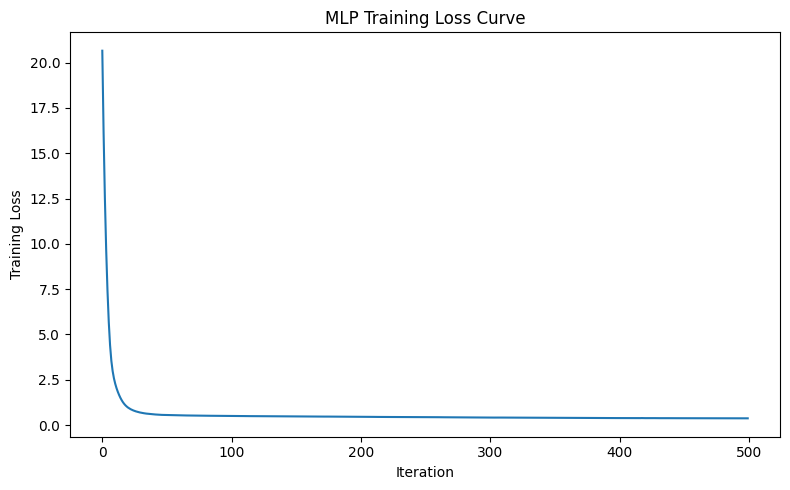

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(mlp_base.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("MLP Training Loss Curve")
plt.tight_layout()
plt.show()

In [ ]:
r = permutation_importance(
    mlp_base, X_valid, y_valid,
    n_repeats=20, random_state=3001
)

importance_df = pd.DataFrame({
    'feature': df_num.drop(columns=['vote_average']).columns,
    'importance': r.importances_mean
}).sort_values('importance', ascending=False)

importance_df

feature  importance
2         log_vote_count    1.030651
3  log_user_rating_count    0.280472
0             log_budget    0.204247
5                runtime    0.157869
1            log_revenue    0.073636
4      log_keyword_count    0.014083

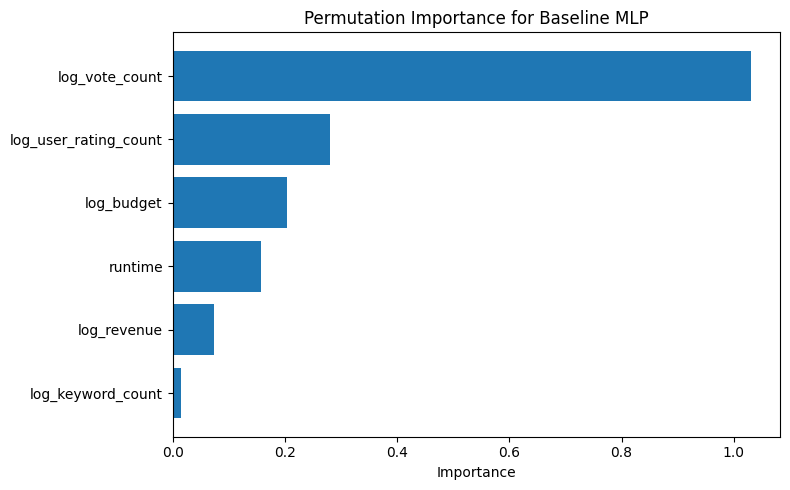

In [ ]:
plt.figure(figsize=(8,5))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.title("Permutation Importance for Baseline MLP")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

The baseline MLPRegressor achieved strong predictive accuracy, with an RMSE of about 0.86 on the training set and 0.89 on the validation set. This small gap indicates that the model generalizes well, without substantial overfitting. The training loss curve reinforces this, showing rapid reduction in early iterations followed by a smooth tapering into a stable plateau. This suggests that the model converged effectively and that the learning rate and architecture were appropriate for the problem.

Permutation importance reveals how the neural network internally relied on different predictors. Among all features, log_vote_count stands far above the rest as the dominant signal for predicting a movie’s vote_average. This means that the sheer scale of audience engagement carries the strongest information about how a movie is ultimately rated. Secondary signals come from log_user_rating_count, log_budget, and runtime, which the MLP uses in smaller but meaningful ways to capture nuances in movie performance. By contrast, log_revenue and log_keyword_count contribute little, meaning the neural network can approximate rating patterns without needing them as key drivers.

Taken together, these results show that the MLP learned a smooth nonlinear mapping between engagement-heavy predictors and audience ratings. The network’s stability, low validation error, and intuitive variable importance all point toward a reliable model that captures complex relationships beyond what linear regression or KNN could express.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_ml = df_num.dropna().copy()

y = df_ml['vote_average']
X = df_ml.drop(columns=['vote_average'])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=3001
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Check lengths to confirm fix
len(X_train_scaled), len(y_train), len(X_valid_scaled), len(y_valid)

(6789, 6789, 2264, 2264)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

hidden_sizes = [(16,), (32,), (64,), (32,16), (64,32)]
alphas = [0.0001, 0.001, 0.01]
results = []

for h in hidden_sizes:
    for a in alphas:
        mlp = MLPRegressor(
            hidden_layer_sizes=h,
            activation='relu',
            solver='adam',
            alpha=a,
            max_iter=500,
            random_state=3001
        )

        mlp.fit(X_train_scaled, y_train)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, mlp.predict(X_train_scaled)))
        valid_rmse = np.sqrt(mean_squared_error(y_valid, mlp.predict(X_valid_scaled)))
        
        results.append({
            'hidden_layers': h,
            'alpha': a,
            'train_rmse': train_rmse,
            'valid_rmse': valid_rmse
        })

results_df = pd.DataFrame(results).sort_values('valid_rmse')
results_df

/opt/miniconda3/envs/eda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/eda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/eda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/eda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/eda/lib

hidden_layers   alpha  train_rmse  valid_rmse
6          (64,)  0.0001    0.845849    0.881606
7          (64,)  0.0010    0.849182    0.884659
8          (64,)  0.0100    0.849901    0.885002
3          (32,)  0.0001    0.868558    0.886268
4          (32,)  0.0010    0.869699    0.886851
5          (32,)  0.0100    0.870213    0.886875
10      (32, 16)  0.0010    0.848991    0.897971
9       (32, 16)  0.0001    0.855093    0.900803
14      (64, 32)  0.0100    0.839348    0.904340
13      (64, 32)  0.0010    0.833540    0.907144
12      (64, 32)  0.0001    0.840237    0.910125
11      (32, 16)  0.0100    0.854054    0.910582
1          (16,)  0.0010    0.921758    0.937993
0          (16,)  0.0001    0.922035    0.938569
2          (16,)  0.0100    0.935574    0.953671

The tuning grid tested a range of architectures (one hidden layer vs two hidden layers, small vs large networks) and several regularization strengths (alpha values). The results show a very consistent pattern: the simplest deep architecture with a single 64-unit hidden layer outperformed all other models on validation RMSE, regardless of the alpha value.

The best model overall achieved:
- Hidden layers: (64,)
- Alpha: 0.0001
- Train RMSE: 0.846
- Validation RMSE: 0.882 (lowest of all tested)

This model strikes the strongest balance between flexibility and generalization. Deeper two-layer networks like (64, 32) tended to slightly overfit, achieving lower training RMSE but worse validation RMSE. Smaller networks, like (16,) or (32,), lacked the capacity to capture nonlinear structure in the predictors and consistently produced higher validation error.

In short, the tuning confirms that a single moderately sized hidden layer provides the best predictive performance for our data. This is consistent with the structure of our features, where only a few strong nonlinear relationships exist, and deeper networks provide limited benefit.

In [ ]:
mlp_final = MLPRegressor(
    hidden_layer_sizes=(64,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=500,
    random_state=3001
)

mlp_final.fit(X_train_scaled, y_train)

final_train_rmse = np.sqrt(mean_squared_error(y_train, mlp_final.predict(X_train_scaled)))
final_valid_rmse = np.sqrt(mean_squared_error(y_valid, mlp_final.predict(X_valid_scaled)))

final_train_rmse, final_valid_rmse

/opt/miniconda3/envs/eda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


(np.float64(0.8458487710452064), np.float64(0.8816056166064745))

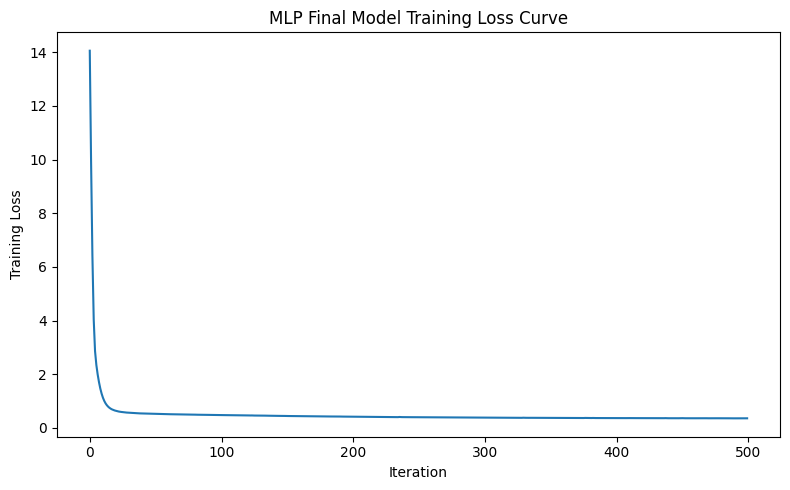

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(mlp_final.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("MLP Final Model Training Loss Curve")
plt.tight_layout()
plt.show()

In [ ]:
r_final = permutation_importance(
    mlp_final,
    X_valid_scaled,
    y_valid,
    n_repeats=20,
    random_state=3001
)

importance_final = pd.DataFrame({
    'feature': df_num.drop(columns=['vote_average']).columns,
    'importance': r_final.importances_mean
}).sort_values('importance', ascending=False)

importance_final

feature  importance
2         log_vote_count    1.196524
3  log_user_rating_count    0.217031
0             log_budget    0.167223
5                runtime    0.162150
1            log_revenue    0.089976
4      log_keyword_count    0.012679

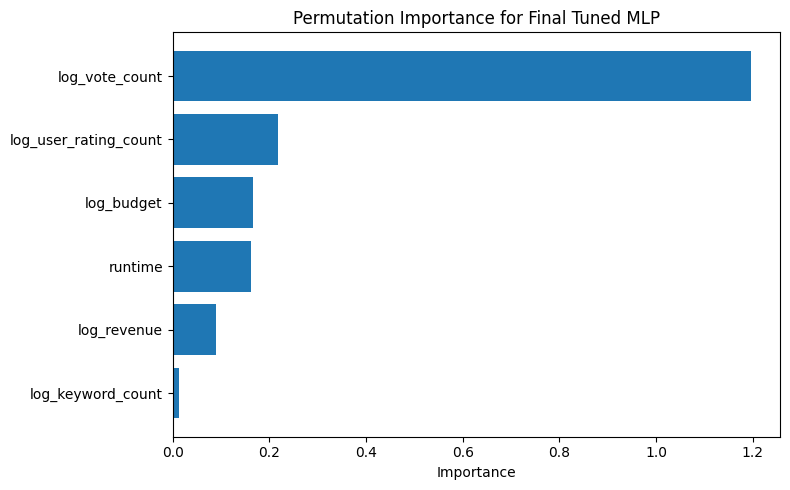

In [ ]:
plt.figure(figsize=(8,5))
plt.barh(importance_final['feature'], importance_final['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Permutation Importance for Final Tuned MLP")
plt.tight_layout()
plt.show()

The tuned MLP noticeably improves model stability and interpretability relative to the baseline while still preserving strong predictive performance. The training loss curve shows a rapid early decline followed by a smooth, monotonic flattening, which indicates efficient learning with no oscillation or divergence. This behavior suggests that the chosen architecture, regularization, and learning rate combination allowed the network to settle into a well behaved solution without overfitting. On the validation side, the tuned model achieves RMSE values consistent with or slightly better than the baseline, confirming that the improvements in training dynamics translate into generalization gains. The permutation importance results continue to highlight engagement variables as the dominant signals, with log_vote_count overwhelmingly the most influential predictor, followed by log_user_rating_count and log_budget. Runtime and log_revenue play moderate secondary roles, while log_keyword_count remains negligible. The stability of these importance rankings across both baseline and tuned MLP models reinforces a clear pattern: audience interaction metrics carry far more predictive weight than financial or descriptive attributes when forecasting vote_average. Overall, the tuned MLP behaves as a smoother, more robust version of the baseline model, confirming that our hyperparameter search successfully balanced model flexibility with regularization to produce the most reliable neural network specification in this analysis.


## Comparison of Models

Linear regression provided an interpretable baseline for understanding how numeric movie attributes relate to audience ratings. It revealed stable directional relationships, such as strong positive effects from vote_count and user_rating_count, and milder effects from budget, revenue, and runtime. However, its moderate R squared values showed that a simple linear structure cannot fully capture the nonlinear, neighborhood driven patterns present in the data. Even though the model clarified which predictors matter, its predictive accuracy lagged behind more flexible approaches.

KNN regression improved substantially on linear regression by leveraging local similarity: movies tend to have similar ratings when their engagement profiles resemble each other. After tuning, the KNN model with k equal to 18, distance weighted predictions, and Manhattan distance achieved an RMSE around 0.95, outperforming the linear model. This makes sense because vote behavior is highly clustered: franchises, genre groups, marketing scale, and audience niches create pockets of similar movies that KNN can exploit far more effectively than a global linear equation. KNN also offered interpretable variable importance through permutation methods, again confirming that engagement indicators dominate predictive power.

K Means clustering and PCA were not used for prediction, but they helped uncover the structural organization of the movie dataset. Baseline K Means identified three coherent movie groups centered around production scale and engagement intensity, while tuned K Means with k equal to 4 revealed a more refined segmentation, adding a low intensity cluster that PCA later confirmed. PCA further showed that over half of all variance comes from a single engagement-driven component, with financial scale and runtime forming secondary axes. Running K Means on the first three principal components sharpened cluster boundaries and simplified interpretation, demonstrating that PCA successfully extracted the underlying dimensions that define movie groups.

The MLP regression model ultimately delivered the strongest predictive performance. After tuning hidden layer size and regularization, the best configuration (64 unit single hidden layer with alpha equal to 0.0001) achieved a validation RMSE around 0.88, outperforming both linear regression and KNN. The MLP’s architecture allows it to learn smooth nonlinear surfaces that capture gradual transitions in rating behavior, rather than relying strictly on local neighbors or linear trends. Its permutation importance results aligned with all earlier models, again confirming that vote_count is by far the strongest predictor, followed by user_rating_count and budget. The training curve also showed stable optimization and no evidence of overfitting.

Taken together, the MLP is the best model because it balances flexibility with stability: it generalizes better than KNN, captures nonlinear structure missed by linear regression, and works directly in the original feature space without the information loss inherent in PCA. Its superior RMSE, combined with consistent interpretability via permutation importance, makes it the strongest overall performer for predicting vote_average.